In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from imblearn.over_sampling import SMOTE  # imblearn library can be installed using pip install imblearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import plotly.graph_objs as go
import plotly .offline as offline
import plotly.figure_factory as ff

In [2]:
#Read in the transaction data file
transactions = pd.read_csv('transaction_data.csv')

In [3]:
transactions.head(5)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
transactions.tail(5)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
2595727,1598,42305362535,711,92130,1,0.99,3228,0.00,1520,102,0.0,0.0
2595728,1598,42305362535,711,114102,1,8.89,3228,0.00,1520,102,0.0,0.0
2595729,1598,42305362535,711,133449,1,6.99,3228,0.00,1520,102,0.0,0.0
2595730,1598,42305362535,711,6923644,1,4.50,3228,-0.49,1520,102,0.0,0.0
2595731,1598,42305362535,711,14055192,1,6.99,3228,0.00,1520,102,0.0,0.0


# CHECKING FOR MISSING VALUES IN THE TRANSACTION DATA FILE

In [5]:
print(transactions.head())
print(transactions.shape)
print(transactions.info())
print(transactions.describe())

   household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  
0       364        -0.60        1631        1          0.0                0.0  
1       364         0.00        1631        1          0.0                0.0  
2       364        -0.30        1631        1          0.0                0.0  
3       364         0.00        1631        1          0.0                0.0  
4       364        -0.39        1631        1          0.0                0.0  
(2595732, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 

# AGGREGATING THE SALES_VALUE VARIABLE BY BASKET_ID TO GET THE TOTAL SALES BY BASKET ID

In [6]:
store_sales = pd.DataFrame({'Total_Sales': transactions.groupby('BASKET_ID')['SALES_VALUE'].sum().sort_values(ascending=True)})
store_sales = store_sales.reset_index()
store_sales

,BASKET_ID,Total_Sales
0,31184741340,0.00
1,41225185620,0.00
2,30627631790,0.00
3,32932195911,0.00
4,40025748519,0.00
...,...,...
276479,30983766334,545.07
276480,32505140858,545.17
276481,33347880492,552.92
276482,40387571385,681.58


# DESCRIPTIVE STATISTICS - SALES_VALUE IN ITS AGGREGATED FORM

In [7]:
store_sales['Total_Sales'].describe()

count    276484.000000
mean         29.142602
std          36.101301
min           0.000000
25%           6.960000
50%          17.070000
75%          36.280000
max         961.490000
Name: Total_Sales, dtype: float64

In [8]:
def converter(column):
    if column==0:
        return "Zero Value Sale"
    elif column>80.26:
        return "Sale Greater than $80.26"
    else:
        return "Not An Outlier"

store_sales['Outlier Indicator'] = store_sales['Total_Sales'].apply(converter)

In [9]:
store_sales['Outlier Indicator'].unique()

array(['Zero Value Sale', 'Not An Outlier', 'Sale Greater than $80.26'],
      dtype=object)

In [10]:
store_sales['Outlier Indicator'] = store_sales['Outlier Indicator'].astype('str')

In [11]:
graphdf=pd.DataFrame({'Total':store_sales.groupby('Outlier Indicator').Total_Sales.count()})

In [12]:
graphdf = graphdf.reset_index()

In [13]:
graphdf['Percentage of Transactions'] = (graphdf['Total'] / graphdf['Total'].sum())*100

In [14]:
graphdf

,Outlier Indicator,Total,Percentage of Transactions
0,Not An Outlier,253312,91.619045
1,Sale Greater than $80.26,22230,8.040248
2,Zero Value Sale,942,0.340707


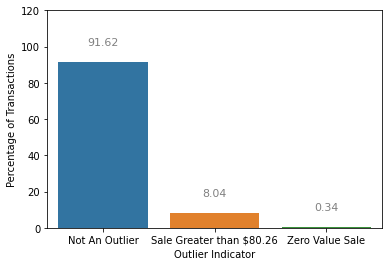

In [15]:
g= sns.barplot(x='Outlier Indicator', y='Percentage of Transactions', data=graphdf)
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,120)

# DESCRIPTIVE STATISTICS - COUPON_DISC VARIABLE

In [16]:
transactions['COUPON_DISC'].describe()

count    2.595732e+06
mean    -1.641600e-02
std      2.168410e-01
min     -5.593000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      0.000000e+00
Name: COUPON_DISC, dtype: float64

# DESCRIPTIVE STATISTICS - DISCREET VARIABLES - TRANSACTIONS FILE

In [17]:
#Number of unique stores
transactions['STORE_ID'].nunique()

582

In [18]:
#Number of unique transaction days
transactions['DAY'].nunique()

711

In [19]:
transactions['WEEK_NO'].nunique()

102

In [20]:
#Number of unique SKUs that the transactions pertained to
transactions['PRODUCT_ID'].nunique()

92339

In [21]:
#Read in the product data file
products = pd.read_csv('product.csv')

In [22]:
products

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,


# CHECKING FOR MISSING VALUES IN THE PRODUCTS DATA FILE

In [23]:
print(products.head())
print(products.shape)
print(products.info())
print(products.describe())

   PRODUCT_ID  MANUFACTURER    DEPARTMENT     BRAND            COMMODITY_DESC  \
0       25671             2       GROCERY  National                  FRZN ICE   
1       26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION   
2       26093            69        PASTRY   Private                     BREAD   
3       26190            69       GROCERY   Private      FRUIT - SHELF STABLE   
4       26355            69       GROCERY   Private             COOKIES/CONES   

            SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
0          ICE - CRUSHED/CUBED                22 LB  
1  NO SUBCOMMODITY DESCRIPTION                       
2         BREAD:ITALIAN/FRENCH                       
3                  APPLE SAUCE                50 OZ  
4            SPECIALTY COOKIES                14 OZ  
(92353, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------         

# DESCRIPTIVE STATISTICS - DISCREET VARIABLES - PRODUCTS FILE

In [24]:
products['DEPARTMENT'].nunique()

44

In [25]:
products['COMMODITY_DESC'].nunique()

308

In [26]:
products['SUB_COMMODITY_DESC'].nunique()

2383

In [27]:
products['PRODUCT_ID'].nunique()

92353

In [28]:
Misc_Sales = products[(products['DEPARTMENT']=='MISC. TRANS.')| (products['DEPARTMENT']=='MISC SALES TRAN')]

In [29]:
Misc_Sales['PRODUCT_ID'].nunique()

578

In [30]:
#Most commonly occuring product categories by department
common_products = pd.DataFrame({'Total_Count': products.groupby('DEPARTMENT')['PRODUCT_ID'].nunique().sort_values(ascending=False)})
common_products = common_products.reset_index()
common_products = common_products.head(20)
common_products

,DEPARTMENT,Total_Count
0,GROCERY,39021
1,DRUG GM,31529
2,PRODUCE,3118
3,COSMETICS,3011
4,NUTRITION,2914
5,MEAT,2544
6,MEAT-PCKGD,2427
7,DELI,2354
8,PASTRY,2149
9,FLORAL,938


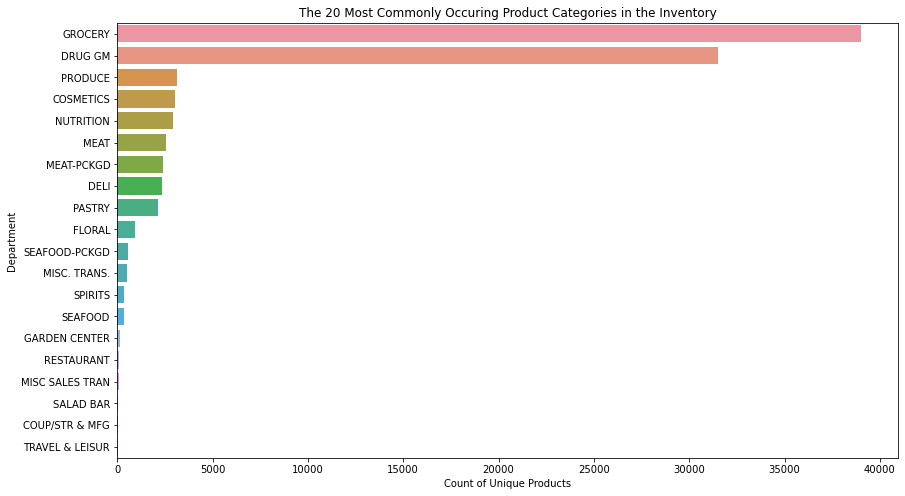

In [31]:
#Plot this with matplotlib and seaborn
#Here, matplotlib is used to fix the plot size, the title of the figure, the title for the axes and to show the figure
#Seaborn is used to do the actual plotting of the data points
figure = plt.figure(figsize=(14,8))
sns.barplot(y='DEPARTMENT', x='Total_Count', data=common_products, orient='h', order=common_products['DEPARTMENT'])
plt.title('The 20 Most Commonly Occuring Product Categories in the Inventory')
plt.xlabel('Count of Unique Products')
plt.ylabel('Department')
plt.show()

In [32]:
def converter(column):
    if column=="NO COMMODITY DESCRIPTION":
        return "NO DESCRIPTION"
    elif column=="COUPON/MISC ITEMS":
        return "COUPON/MISC"
    else:
        return "ORDINARY ITEM"

In [33]:
products['Item Indicator'] = products['COMMODITY_DESC'].apply(converter)

In [34]:
graphdf=pd.DataFrame({'Total':products.groupby('Item Indicator').PRODUCT_ID.nunique()})

In [35]:
graphdf

,Total
Item Indicator,
COUPON/MISC,128
NO DESCRIPTION,490
ORDINARY ITEM,91735


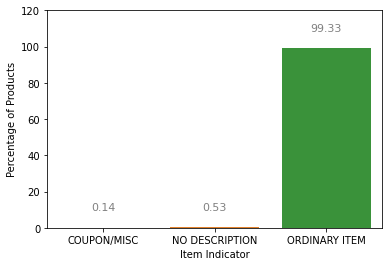

In [36]:
graphdf = graphdf.reset_index()
graphdf['Percentage of Products'] = (graphdf['Total'] / graphdf['Total'].sum())*100
graphdf
g= sns.barplot(x='Item Indicator', y='Percentage of Products', data=graphdf)
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,120)

# OUTLIER DETECTION - SALES_VALUE GREATER THAN 80.26

In [37]:
Large_Sales_Value_Transactions = store_sales[store_sales['Total_Sales']>80.26]

In [38]:
Large_Sales_Value_Transactions['BASKET_ID'].nunique()

22230

# OUTLIER DETECTION - SALES_VALUE EQUAL TO 0

In [39]:
Zero_Sales_Value_Transactions = store_sales[store_sales['Total_Sales']==0]

In [40]:
Zero_Sales_Value_Transactions['BASKET_ID'].nunique()

942

# REMOVAL OF TRANSACTIONS WITH ZERO SALES VALUE

In [41]:
#Remove records with zero sales value
transactions_without_zero_sales_value = transactions[transactions['SALES_VALUE']!=0]
transactions_without_zero_sales_value

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2595727,1598,42305362535,711,92130,1,0.99,3228,0.00,1520,102,0.0,0.0
2595728,1598,42305362535,711,114102,1,8.89,3228,0.00,1520,102,0.0,0.0
2595729,1598,42305362535,711,133449,1,6.99,3228,0.00,1520,102,0.0,0.0
2595730,1598,42305362535,711,6923644,1,4.50,3228,-0.49,1520,102,0.0,0.0


In [42]:
#How many unique transactions are there whose sales value is not equal to 0?
transactions_without_zero_sales_value['BASKET_ID'].nunique()

275542

# MERGING THE PRODUCT AND TRANSACTION DATA FILES TO GAIN MORE INSIGHTS

In [43]:
product_transactions = pd.merge(transactions_without_zero_sales_value, products, on='PRODUCT_ID', how='left')

In [44]:
#Most popular product categories by sales revenue 
popular_product_categories = pd.DataFrame({'Total_Sales_Revenue': product_transactions.groupby('DEPARTMENT')['SALES_VALUE'].sum().sort_values(ascending=False)})
popular_product_categories = popular_product_categories.reset_index()
popular_product_categories = popular_product_categories.head(20)
popular_product_categories

,DEPARTMENT,Total_Sales_Revenue
0,GROCERY,4.093814e+06
1,DRUG GM,1.055358e+06
2,PRODUCE,5.574521e+05
3,MEAT,5.487868e+05
4,KIOSK-GAS,5.442223e+05
5,MEAT-PCKGD,4.124368e+05
6,DELI,2.608665e+05
7,PASTRY,1.217399e+05
8,MISC SALES TRAN,1.199600e+05
9,NUTRITION,9.766904e+04


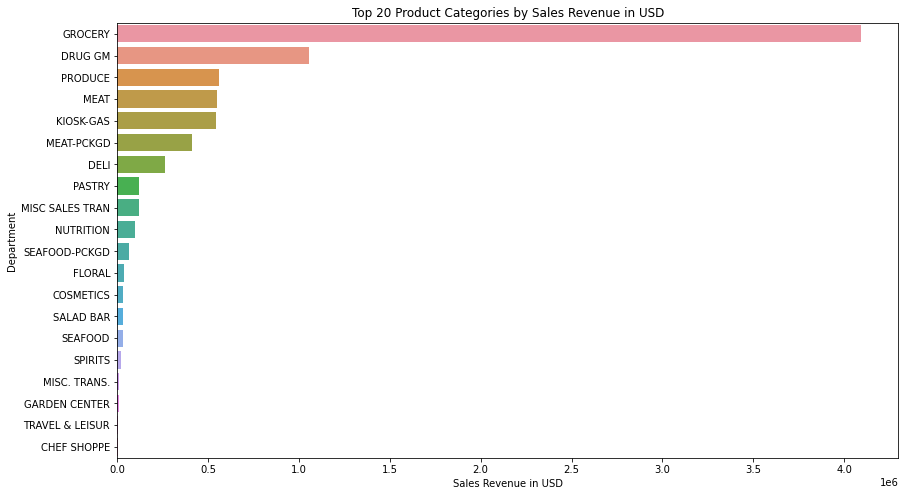

In [45]:
#Plot this with matplotlib and seaborn
#Here, matplotlib is used to fix the plot size, the title of the figure, the title for the axes and to show the figure
#Seaborn is used to do the actual plotting of the data points
figure = plt.figure(figsize=(14,8))
sns.barplot(y='DEPARTMENT', x='Total_Sales_Revenue', data=popular_product_categories, orient='h', order=popular_product_categories['DEPARTMENT'])
plt.title('Top 20 Product Categories by Sales Revenue in USD')
plt.xlabel('Sales Revenue in USD')
plt.ylabel('Department')
plt.show()

In [46]:
def converter(column):
    if column=="NO COMMODITY DESCRIPTION":
        return "NO DESCRIPTION"
    elif column=="COUPON/MISC ITEMS":
        return "COUPON/MISC"
    else:
        return "ORDINARY ITEM"

In [47]:
product_transactions['Item Indicator'] = product_transactions['COMMODITY_DESC'].apply(converter)

In [48]:
graphdf=pd.DataFrame({'Total':product_transactions.groupby('Item Indicator').BASKET_ID.nunique()})

In [49]:
graphdf

,Total
Item Indicator,
COUPON/MISC,27585
NO DESCRIPTION,2201
ORDINARY ITEM,252616


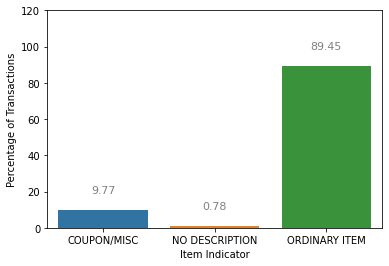

In [50]:
graphdf = graphdf.reset_index()
graphdf['Percentage of Transactions'] = (graphdf['Total'] / graphdf['Total'].sum())*100
graphdf
g= sns.barplot(x='Item Indicator', y='Percentage of Transactions', data=graphdf)
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,120)

In [51]:
graphdf=pd.DataFrame({'Total':product_transactions.groupby('Item Indicator').SALES_VALUE.sum()})

In [52]:
graphdf

,Total
Item Indicator,
COUPON/MISC,6.398786e+05
NO DESCRIPTION,1.067869e+04
ORDINARY ITEM,7.406906e+06


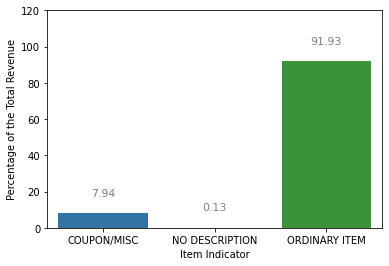

In [53]:
graphdf = graphdf.reset_index()
graphdf['Percentage of the Total Revenue'] = (graphdf['Total'] / graphdf['Total'].sum())*100
graphdf
g= sns.barplot(x='Item Indicator', y='Percentage of the Total Revenue', data=graphdf)
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,120)

# DESCRIPTIVE STATISTICS - DISCREET VARIABLES - FROM PRODUCT TRANSACTIONS FILE

In [54]:
#Unique Transaction IDs
product_transactions['BASKET_ID'].nunique()

275542

In [55]:
#Unique categories and sub-categories
product_transactions['COMMODITY_DESC'].nunique()

307

In [56]:
product_transactions['SUB_COMMODITY_DESC'].nunique()

2373

In [57]:
#Any instances with coupon product descriptions?
#Using Regex (Regular Expresions)
product_transactions['COMMODITY_DESC'].str.count('COUPON').sum()

28140

# PLEASE NOTE - IN ORDER TO ACCURATELY ASSESS CUSTOMER CHURN BEHAVIOUR, TRANSACTIONS PERTAINING TO ALL PRODUCT CATEGORIES ARE BEING KEPT IN THE DATA SET INCLUDING THE COUPON PRODUCT CATEGORY

# INSIGHTS FROM EXISTING VARIABLES IN THE TRANSACTION DATA FILE

In [58]:
grouped_sum_household = transactions_without_zero_sales_value.groupby("household_key").sum()

In [59]:
grouped_sum_household

,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
household_key,,,,,,,,,,,
1,58329660000580,672597,5190137623,1994,4330.16,1022937,-685.07,2374812,97272,-73.31,-26.15
2,24146994059535,273349,2125503676,833,1954.34,8210259,-333.50,1282298,39562,-9.00,0.00
3,29227047220571,279183,2505135526,8538,2653.21,358375,-668.28,1521348,40450,-61.19,-19.80
4,9425657172476,81364,812450552,382,1200.11,93666,-115.65,478339,11882,-2.50,0.00
5,6962167980793,61087,677228224,245,779.06,106344,-118.33,410059,8911,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2496,50693058160442,599137,4310124140,130304,4339.66,547269,-1115.09,2100224,86383,-34.60,-12.40
2497,65965786424052,748872,4580473877,61236,7111.98,53804077,-1341.03,2889752,108420,-15.84,-0.75
2498,29792538323975,372335,2880739025,31339,2601.60,568095,-279.40,1443766,53791,0.00,0.00


In [60]:
grouped_sum_transactions = transactions_without_zero_sales_value.groupby("BASKET_ID").sum()

In [61]:
grouped_sum_transactions

,household_key,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
BASKET_ID,,,,,,,,,,,
26984851472,11875,5,12316988,5,5.91,1820,-1.29,8155,5,0.0,0.0
26984851516,14250,6,19969639,7,12.43,2184,-3.26,9852,6,0.0,0.0
26984896261,6820,5,4580095,5,11.37,158710,-2.18,7600,5,0.0,0.0
26984905972,5650,5,4843303,9,2.55,158210,-2.08,6700,5,0.0,0.0
26984945254,3519,3,2879722,4,3.53,1236,0.00,6126,3,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
42302712006,9048,2844,17160884,4,9.78,1784,-1.79,6608,408,0.0,0.0
42302712189,6845,3555,13309990,6,33.64,2230,-1.10,8650,510,0.0,0.0
42302712298,24475,7821,41324039,11,40.70,4906,-0.39,19294,1122,0.0,0.0


In [62]:
#Average Order Value - revenue in terms of transactions
average_order_value = round(transactions_without_zero_sales_value['SALES_VALUE'].sum()/len(grouped_sum_transactions), 1)
average_order_value

29.2

In [63]:
#If I used the mean function, I was getting incorrect results - the revenue number was too small
#Average Revenue per household
average_revenue = round(transactions_without_zero_sales_value['SALES_VALUE'].sum()/len(grouped_sum_household), 1)
average_revenue

3223.0

In [64]:
#Average number of unique products purchased
average_number_of_unique_products_purchased = round(len(transactions_without_zero_sales_value.groupby(['household_key', 'PRODUCT_ID']).nunique())/len(grouped_sum_household),1)
average_number_of_unique_products_purchased

557.0

In [65]:
#Average number of store visits
average_number_of_store_visits = round(len(transactions_without_zero_sales_value.groupby(['household_key', 'DAY']).nunique())/len(grouped_sum_household),1)
average_number_of_store_visits

90.1

In [66]:
#Top 20 stores by sales
store_sales = pd.DataFrame({'Total_Sales': transactions_without_zero_sales_value.groupby('STORE_ID')['SALES_VALUE'].sum().sort_values(ascending=False)})
store_sales = store_sales.reset_index()
store_sales = store_sales.head(20)
store_sales

,STORE_ID,Total_Sales
0,367,267614.34
1,406,216781.77
2,361,144698.85
3,429,142391.01
4,343,140455.75
5,356,137588.68
6,381,132488.15
7,375,130396.51
8,292,130005.18
9,31782,121726.54


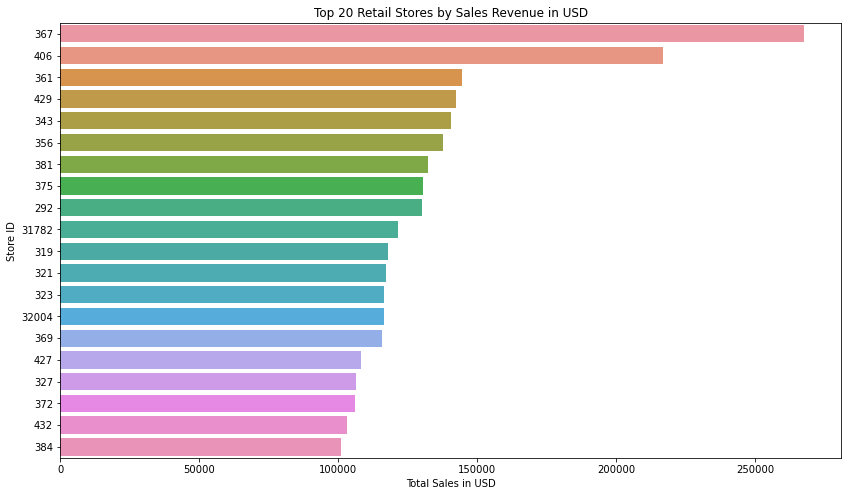

In [67]:
#Plot this with matplotlib and seaborn
#Here, matplotlib is used to fix the plot size, the title of the figure, the title for the axes and to show the figure
#Seaborn is used to do the actual plotting of the data points
figure = plt.figure(figsize=(14,8))
sns.barplot(y='STORE_ID', x='Total_Sales', data=store_sales, orient='h', order=store_sales['STORE_ID'])
plt.title('Top 20 Retail Stores by Sales Revenue in USD')
plt.xlabel('Total Sales in USD')
plt.ylabel('Store ID')
plt.show()

In [68]:
#Also plot bottom 20 stores to see if these are the stores with the highest churn rates
#Top 20 stores by sales
store_sales = pd.DataFrame({'Total_Sales': transactions_without_zero_sales_value.groupby('STORE_ID')['SALES_VALUE'].sum().sort_values(ascending=True)})
store_sales = store_sales.reset_index()
store_sales = store_sales.head(20)
store_sales

,STORE_ID,Total_Sales
0,610,0.50
1,256,0.76
2,639,0.85
3,551,1.00
4,765,1.00
5,2760,1.00
6,3209,1.19
7,1433,1.29
8,30719,1.49
9,2825,1.54


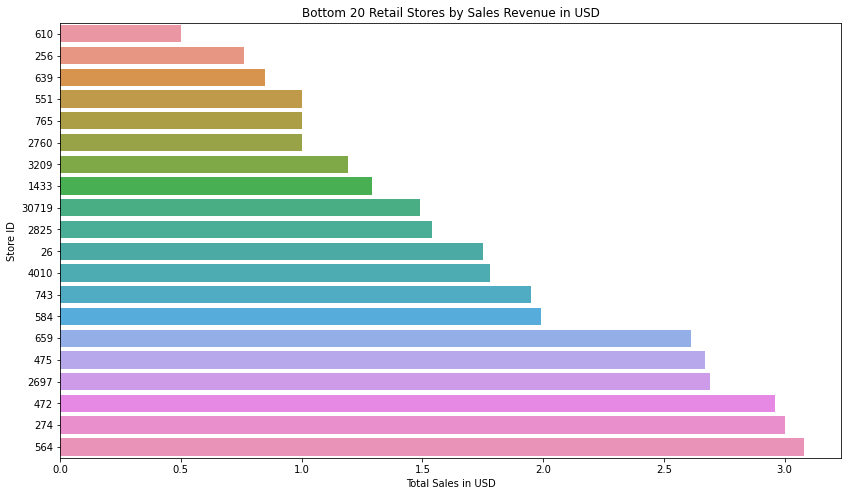

In [69]:
#Plot this with matplotlib and seaborn
#Here, matplotlib is used to fix the plot size, the title of the figure, the title for the axes and to show the figure
#Seaborn is used to do the actual plotting of the data points
figure = plt.figure(figsize=(14,8))
sns.barplot(y='STORE_ID', x='Total_Sales', data=store_sales, orient='h', order=store_sales['STORE_ID'])
plt.title('Bottom 20 Retail Stores by Sales Revenue in USD')
plt.xlabel('Total Sales in USD')
plt.ylabel('Store ID')
plt.show()

In [70]:
#Who are the top 20 customers (households) in terms of revenue?
top_20_customers = pd.DataFrame({'Total Sales by Household': transactions_without_zero_sales_value.groupby('household_key')['SALES_VALUE'].sum().sort_values(ascending=False)})
top_20_customers = top_20_customers.reset_index()
top_20_customers = top_20_customers.head(20)
top_20_customers

,household_key,Total Sales by Household
0,1023,38319.79
1,1609,27859.68
2,2322,23646.92
3,1453,21661.29
4,2459,20671.50
5,1430,20352.99
6,718,19299.86
7,707,19194.42
8,1653,19153.75
9,1111,18894.72


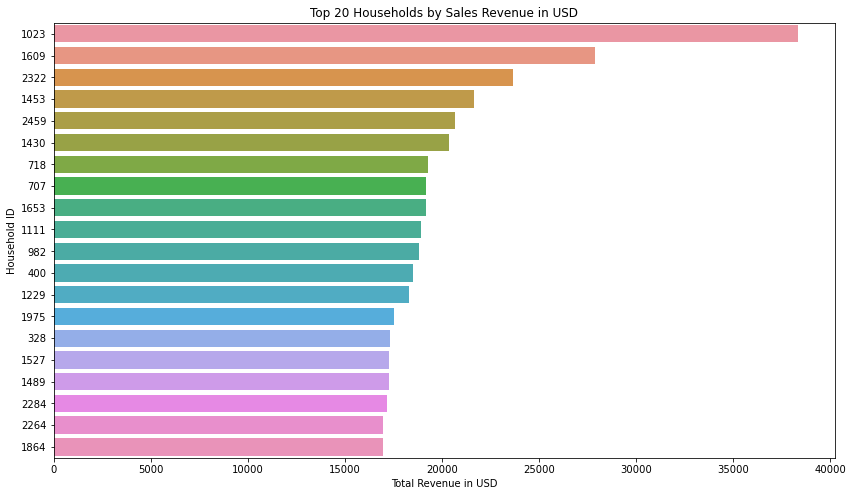

In [71]:
figure = plt.figure(figsize=(14,8))
sns.barplot(y='household_key', x='Total Sales by Household', data=top_20_customers, orient='h', order=top_20_customers['household_key'])
plt.title('Top 20 Households by Sales Revenue in USD')
plt.xlabel('Total Revenue in USD')
plt.ylabel('Household ID')
plt.show()

In [72]:
#Also plot bottom 20 households to see if these are the households that churned
#Bottom 20 customers by sales revenue
bottom_20_customers = pd.DataFrame({'Total Sales by Household': transactions_without_zero_sales_value.groupby('household_key')['SALES_VALUE'].sum().sort_values(ascending=True)})
bottom_20_customers = bottom_20_customers.reset_index()
bottom_20_customers = bottom_20_customers.head(20)
bottom_20_customers

,household_key,Total Sales by Household
0,494,8.17
1,1897,19.58
2,2201,27.51
3,689,28.96
4,522,29.34
5,11,33.39
6,1984,38.94
7,1830,39.44
8,1626,42.96
9,1647,50.49


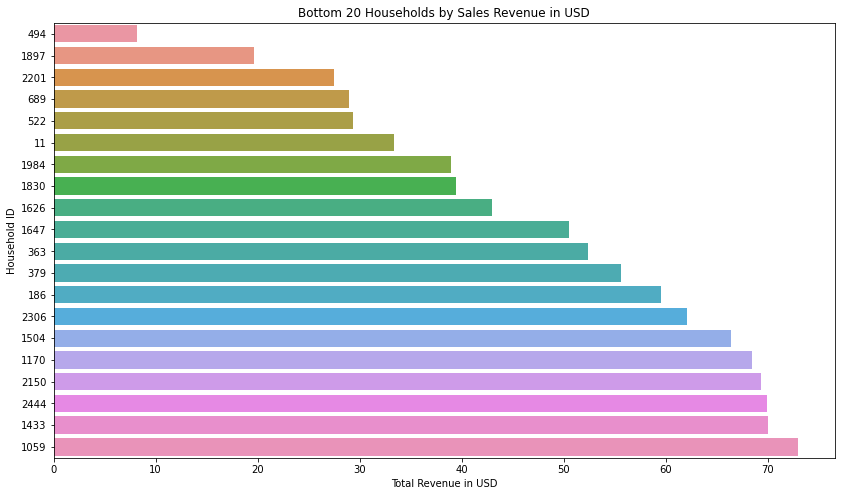

In [73]:
figure = plt.figure(figsize=(14,8))
sns.barplot(y='household_key', x='Total Sales by Household', data=bottom_20_customers, orient='h', order=bottom_20_customers['household_key'])
plt.title('Bottom 20 Households by Sales Revenue in USD')
plt.xlabel('Total Revenue in USD')
plt.ylabel('Household ID')
plt.show()

# CALCULATION OF THE CHURN VARIABLE

In [74]:
#Set the churn threshold as two weeks
#Two weeks is justifiable as we are talking about frequent shoppers
#See how severe the imbalance is - if severe then reduce the churn threshold
Churn = pd.DataFrame({'LATEST PURCHASE WEEK BY HOUSEHOLD': transactions_without_zero_sales_value.groupby('household_key')['WEEK_NO'].max()})
Churn = Churn.reset_index()
Churn

,household_key,LATEST PURCHASE WEEK BY HOUSEHOLD
0,1,102
1,2,96
2,3,101
3,4,90
4,5,101
...,...,...
2495,2496,98
2496,2497,101
2497,2498,102
2498,2499,102


In [75]:
Churn['LATEST PURCHASE WEEK OVERALL'] = Churn['LATEST PURCHASE WEEK BY HOUSEHOLD'].max()

In [76]:
Churn['NUMBER OF CHURNED WEEKS'] = Churn['LATEST PURCHASE WEEK OVERALL'] - Churn['LATEST PURCHASE WEEK BY HOUSEHOLD']

In [77]:
Churn['NUMBER OF CHURNED WEEKS'].describe()

count    2500.000000
mean        3.419200
std         8.957386
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        94.000000
Name: NUMBER OF CHURNED WEEKS, dtype: float64

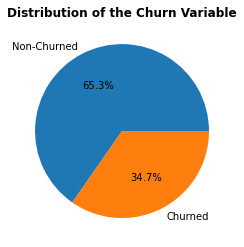

In [78]:
Churn['CHURN_THRESHOLD'] = 2
Churn['CHURNED'] = Churn['NUMBER OF CHURNED WEEKS']>=Churn['CHURN_THRESHOLD']
Churn.CHURNED.value_counts().plot(kind="pie",autopct="%.1f%%",labels=["Non-Churned","Churned"])
plt.ylabel("")
plt.title("Distribution of the Churn Variable",fontweight="bold")
plt.show()

In [79]:
#Get info on the Churn data set
Churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   household_key                      2500 non-null   int64
 1   LATEST PURCHASE WEEK BY HOUSEHOLD  2500 non-null   int64
 2   LATEST PURCHASE WEEK OVERALL       2500 non-null   int64
 3   NUMBER OF CHURNED WEEKS            2500 non-null   int64
 4   CHURN_THRESHOLD                    2500 non-null   int64
 5   CHURNED                            2500 non-null   bool 
dtypes: bool(1), int64(5)
memory usage: 100.2 KB


In [80]:
#Create a copy of the churn variable
Churn['CHURNED_Copy'] = Churn['CHURNED'] 

In [81]:
#Convert the boolen variable into a string variable
Churn['CHURNED'] = Churn['CHURNED'].astype(str)

In [82]:
Churn['CHURNED'].unique()

array(['False', 'True'], dtype=object)

In [83]:
#Define a function to convert the True and False values into a string and apply it to the churn column
def churn(CHURNED):
    if CHURNED=="True":
        return "Churned"
    else:
        return "Not Churned"
    
Churn['Churn Indicator'] = Churn['CHURNED'].apply(churn)

In [84]:
#Get a sense of the distribution of churned vs. non-churned households
churned_not_churned = pd.DataFrame({'Total': Churn.groupby('Churn Indicator')['household_key'].nunique()})
churned_not_churned = churned_not_churned.reset_index()
churned_not_churned['Percentage'] = (churned_not_churned['Total']/churned_not_churned['Total'].sum())*100
churned_not_churned

,Churn Indicator,Total,Percentage
0,Churned,867,34.68
1,Not Churned,1633,65.32


In [85]:
#Define a function to convert the True and False values into a string and apply it to the churn column
def churn(CHURNED):
    if CHURNED=="True":
        return 1
    else:
        return 0
    
Churn['Churn Variable'] = Churn['CHURNED'].apply(churn)

In [86]:
Churn_copy = Churn[['household_key', 'Churn Variable', 'CHURNED_Copy']]

In [87]:
Churn = Churn[['household_key', 'Churn Variable']]

In [88]:
Churn

,household_key,Churn Variable
0,1,0
1,2,1
2,3,0
3,4,1
4,5,0
...,...,...
2495,2496,1
2496,2497,0
2497,2498,0
2498,2499,0


# FEATURE CREATION: CREATION OF DUMMY VARIABLES FOR STORES THAT HAVE THE MOST CHURNED HOUSEHOLDS

In [89]:
#First get a list of stores that each house buys from
store_per_house = transactions_without_zero_sales_value.groupby("household_key")["STORE_ID"].apply(list).apply(np.unique)

In [90]:
store_per_house

household_key
1                                            [436, 31401]
2                            [296, 401, 406, 3278, 31782]
3                                         [296, 330, 401]
4                          [298, 356, 359, 365, 370, 404]
5                                       [374, 2786, 2987]
                              ...                        
2496                                      [365, 370, 404]
2497    [304, 339, 343, 358, 369, 384, 421, 445, 448, ...
2498             [309, 432, 433, 3072, 3149, 3163, 31862]
2499      [197, 292, 296, 330, 343, 384, 406, 447, 31782]
2500        [296, 327, 330, 372, 396, 401, 406, 442, 447]
Name: STORE_ID, Length: 2500, dtype: object

In [91]:
#Subset the Churn_copy data frame by only including those households that have churned and hence, for which the value of the target variable is 1
Churn_copy[Churn_copy['CHURNED_Copy']==True]

,household_key,Churn Variable,CHURNED_Copy
1,2,1,True
3,4,1,True
8,9,1,True
9,10,1,True
10,11,1,True
...,...,...,...
2489,2490,1,True
2490,2491,1,True
2492,2493,1,True
2494,2495,1,True


In [92]:
churn_houses = set(Churn_copy.household_key[Churn_copy.CHURNED_Copy == True].sort_values().values)

In [93]:
churn_stores = []
for i in churn_houses:
    churn_stores.extend(store_per_house[i])

In [94]:
churn_stores

[341,
 484,
 296,
 401,
 406,
 3278,
 31782,
 338,
 358,
 448,
 31742,
 31762,
 298,
 356,
 359,
 365,
 370,
 404,
 295,
 334,
 400,
 296,
 324,
 372,
 292,
 297,
 343,
 441,
 403,
 432,
 31862,
 370,
 404,
 215,
 324,
 406,
 31642,
 309,
 3316,
 320,
 346,
 361,
 34280,
 324,
 327,
 427,
 298,
 313,
 318,
 360,
 404,
 410,
 424,
 289,
 313,
 318,
 360,
 404,
 410,
 379,
 634,
 403,
 404,
 345,
 370,
 313,
 318,
 365,
 370,
 404,
 31582,
 292,
 316,
 343,
 412,
 438,
 441,
 324,
 338,
 358,
 381,
 382,
 448,
 31742,
 31762,
 33923,
 292,
 304,
 343,
 438,
 313,
 320,
 333,
 401,
 319,
 320,
 297,
 304,
 340,
 381,
 412,
 446,
 450,
 31642,
 300,
 436,
 300,
 310,
 352,
 422,
 436,
 2971,
 31401,
 288,
 323,
 343,
 374,
 311,
 298,
 310,
 313,
 318,
 335,
 358,
 361,
 365,
 370,
 403,
 439,
 31582,
 321,
 410,
 424,
 298,
 318,
 321,
 335,
 352,
 404,
 410,
 424,
 354,
 368,
 414,
 450,
 34011,
 306,
 354,
 389,
 391,
 415,
 3278,
 334,
 339,
 356,
 367,
 442,
 31782,
 309,
 310,
 335,


In [95]:
churn_stores = pd.Series(churn_stores).value_counts()/len(churn_houses)

In [96]:
churn_stores

381      0.077278
367      0.073818
372      0.069204
343      0.065744
412      0.062284
           ...   
3672     0.001153
3311     0.001153
3293     0.001153
1240     0.001153
30733    0.001153
Length: 363, dtype: float64

In [97]:
transactions_without_zero_sales_value['STORE_ID'].nunique()

581

In [98]:
df_store = transactions_without_zero_sales_value.groupby(["STORE_ID","household_key"]).count()["BASKET_ID"].unstack("STORE_ID")

In [99]:
df_store

STORE_ID,1,2,12,19,20,21,22,26,27,37,...,33863,33904,33923,33985,34007,34011,34016,34037,34038,34280
household_key,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
df_store.replace(np.nan,0,inplace=True)

In [101]:
df_store

STORE_ID,1,2,12,19,20,21,22,26,27,37,...,33863,33904,33923,33985,34007,34011,34016,34037,34038,34280
household_key,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
df_store

STORE_ID,1,2,12,19,20,21,22,26,27,37,...,33863,33904,33923,33985,34007,34011,34016,34037,34038,34280
household_key,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
#select the top stores with high number of churners
df_store = df_store.loc[:,churn_stores.index[:20]]

In [104]:
df_store

,381,367,372,343,412,318,375,321,424,298,450,31782,446,445,292,335,421,296,380,313
household_key,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,0.0,0.0,0.0,0.0,118.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,4.0,0.0,0.0,0.0
2498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
df_store.columns=["Store_"+str(i) for i in df_store.columns]

In [106]:
df_store = df_store.reset_index()

In [107]:
df_store

,household_key,Store_381,Store_367,Store_372,Store_343,Store_412,Store_318,Store_375,Store_321,Store_424,...,Store_450,Store_31782,Store_446,Store_445,Store_292,Store_335,Store_421,Store_296,Store_380,Store_313
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,252.0,0.0,0.0,0.0,0.0,0.0,118.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,2497,0.0,0.0,0.0,124.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,22.0,0.0,0.0,4.0,0.0,0.0,0.0
2497,2498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2499,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,147.0,0.0,0.0,12.0,0.0,0.0,2.0,0.0,0.0


# FEATURE CREATION: ACTUAL AMOUNT SPENT BY HOUSEHOLDS, RECENCY, FREQUENCY AND MONETARY METRICS

In [108]:
transactions_without_zero_sales_value['ACTUAL AMOUNT SPENT BY HOUSEHOLD'] = transactions_without_zero_sales_value['SALES_VALUE'] + transactions_without_zero_sales_value['COUPON_DISC']

# GROUP ACTUAL AMOUNT SPENT BY BASKET_ID TO GET SOME DESCRIPTIVE STATS

In [109]:
actual_amount = pd.DataFrame({'Total_Actual_Amount_Spent': transactions_without_zero_sales_value.groupby('BASKET_ID')['ACTUAL AMOUNT SPENT BY HOUSEHOLD'].sum().sort_values(ascending=True)})
actual_amount = actual_amount.reset_index()
actual_amount['Total_Actual_Amount_Spent'].describe()

count    275542.000000
mean         29.125245
std          35.926621
min           0.000000
25%           6.990000
50%          17.130000
75%          36.270000
max         961.490000
Name: Total_Actual_Amount_Spent, dtype: float64

In [110]:
actual_amount['BASKET_ID'].nunique()

275542

# TOP 20 HOUSEHOLDS BY TOTAL ACTUAL AMOUNT SPENT

In [111]:
top_20_customers_actual_amount_spent = pd.DataFrame({'Total Actual Amount Spent by Household': transactions_without_zero_sales_value.groupby('household_key')['ACTUAL AMOUNT SPENT BY HOUSEHOLD'].sum().sort_values(ascending=False)})
top_20_customers_actual_amount_spent = top_20_customers_actual_amount_spent.reset_index()
top_20_customers_actual_amount_spent = top_20_customers_actual_amount_spent.head(20)
top_20_customers_actual_amount_spent

,household_key,Total Actual Amount Spent by Household
0,1023,38289.21
1,1609,27801.54
2,2322,23629.32
3,1453,21590.16
4,2459,20552.11
5,1430,20319.99
6,707,19185.57
7,1653,19125.47
8,718,19049.02
9,1111,18889.68


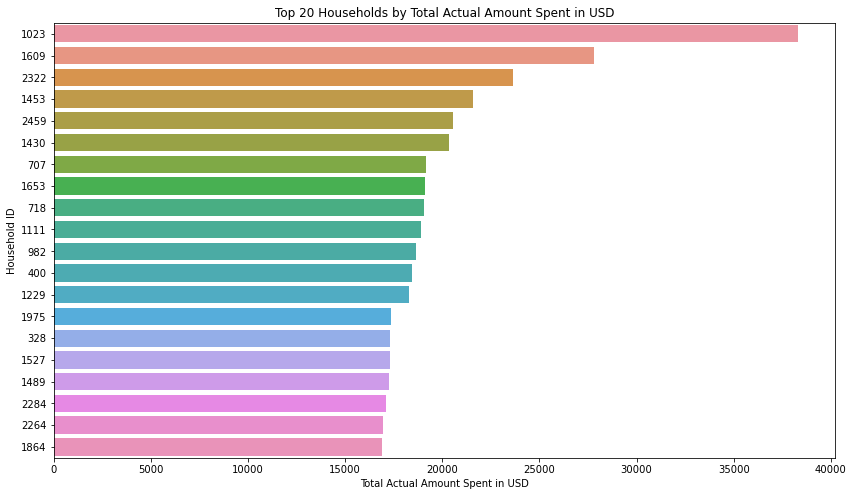

In [112]:
figure = plt.figure(figsize=(14,8))
sns.barplot(y='household_key', x='Total Actual Amount Spent by Household', data=top_20_customers_actual_amount_spent, orient='h', order=top_20_customers_actual_amount_spent['household_key'])
plt.title('Top 20 Households by Total Actual Amount Spent in USD')
plt.xlabel('Total Actual Amount Spent in USD')
plt.ylabel('Household ID')
plt.show()

# BOTTOM 20 HOUSEHOLDS BY TOTAL ACTUAL AMOUNT SPENT

In [113]:
bottom_20_customers_actual_amount_spent = pd.DataFrame({'Total Actual Amount Spent by Household': transactions_without_zero_sales_value.groupby('household_key')['ACTUAL AMOUNT SPENT BY HOUSEHOLD'].sum().sort_values(ascending=True)})
bottom_20_customers_actual_amount_spent = bottom_20_customers_actual_amount_spent.reset_index()
bottom_20_customers_actual_amount_spent = bottom_20_customers_actual_amount_spent.head(20)
bottom_20_customers_actual_amount_spent

,household_key,Total Actual Amount Spent by Household
0,494,8.17
1,1897,19.58
2,2201,27.51
3,689,28.96
4,522,29.34
5,11,33.39
6,1984,38.94
7,1830,39.44
8,1626,42.96
9,1647,50.49


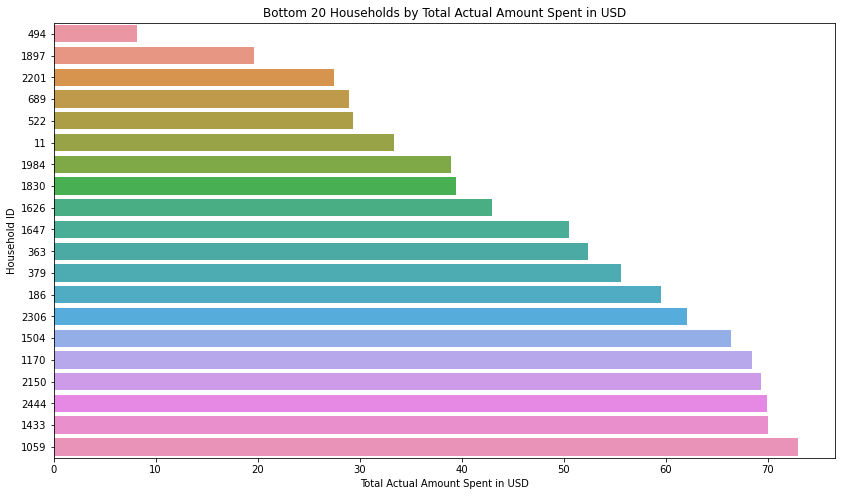

In [114]:
figure = plt.figure(figsize=(14,8))
sns.barplot(y='household_key', x='Total Actual Amount Spent by Household', data=bottom_20_customers_actual_amount_spent, orient='h', order=bottom_20_customers_actual_amount_spent['household_key'])
plt.title('Bottom 20 Households by Total Actual Amount Spent in USD')
plt.xlabel('Total Actual Amount Spent in USD')
plt.ylabel('Household ID')
plt.show()

# HOW MANY TRANSACTIONS HAD AN ACTUAL SPEND AMOUNT OF ZERO DOLLARS?

In [115]:
def converter(column):
    if column==0:
        return "Zero Spend Amount"
    else:
        return "Spend Amount Greater than Zero"

actual_amount['Outlier Indicator'] = actual_amount['Total_Actual_Amount_Spent'].apply(converter)

In [116]:
actual_amount['Outlier Indicator'].unique()

array(['Zero Spend Amount', 'Spend Amount Greater than Zero'],
      dtype=object)

In [117]:
actual_amount['Outlier Indicator'] = actual_amount['Outlier Indicator'].astype('str')

In [118]:
graphdf=pd.DataFrame({'Total':actual_amount.groupby('Outlier Indicator').Total_Actual_Amount_Spent.count()})
graphdf = graphdf.reset_index()
graphdf['Percentage of Transactions'] = (graphdf['Total'] / graphdf['Total'].sum())*100
graphdf

,Outlier Indicator,Total,Percentage of Transactions
0,Spend Amount Greater than Zero,275521,99.992379
1,Zero Spend Amount,21,0.007621


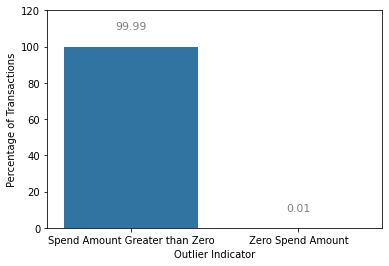

In [119]:
g= sns.barplot(x='Outlier Indicator', y='Percentage of Transactions', data=graphdf)
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,120)

In [120]:
actual_amount_zero_transactions = actual_amount[actual_amount['Total_Actual_Amount_Spent']==0]

In [121]:
actual_amount_zero_transactions_list = actual_amount_zero_transactions['BASKET_ID'].tolist()
actual_amount_zero_transactions_list

[31269196856,
 33027755775,
 40703036574,
 28941321594,
 31687222488,
 28790130506,
 40955350837,
 31748187350,
 32505396536,
 33362858290,
 36027966193,
 34186200686,
 33168228444,
 31355497112,
 30731437074,
 30578452450,
 28629237734,
 40025462867,
 34641742557,
 30037082661,
 40341816060]

In [122]:
transactions_without_zero_sales_value

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,ACTUAL AMOUNT SPENT BY HOUSEHOLD
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,0.99
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595727,1598,42305362535,711,92130,1,0.99,3228,0.00,1520,102,0.0,0.0,0.99
2595728,1598,42305362535,711,114102,1,8.89,3228,0.00,1520,102,0.0,0.0,8.89
2595729,1598,42305362535,711,133449,1,6.99,3228,0.00,1520,102,0.0,0.0,6.99
2595730,1598,42305362535,711,6923644,1,4.50,3228,-0.49,1520,102,0.0,0.0,4.50


In [123]:
#Remove these 21 transactions from the data frame transactions_without_zero_sales_value
transactions_without_zero_sales_value = transactions_without_zero_sales_value[~transactions_without_zero_sales_value.BASKET_ID.isin(actual_amount_zero_transactions_list)]

In [124]:
#Calculation of Recency Score
#First, identify the largest value of the DAY column
transactions_without_zero_sales_value['DAY'].max()

711

# RECENCY VALUE CALCULATION

In [125]:
#The latest purchase day is day 711
#Recency value = latest purchase day - day on which the transaction occurred
#First, group each household by their latest purchase day
#Recency

Recency = pd.DataFrame({'LATEST PURCHASE DATE BY HOUSEHOLD': transactions_without_zero_sales_value.groupby('household_key')['DAY'].max()})
Recency = Recency.reset_index()
Recency['LATEST PURCHASE DATE OVERALL'] = Recency['LATEST PURCHASE DATE BY HOUSEHOLD'].max()
Recency['Recency Value'] = Recency['LATEST PURCHASE DATE OVERALL'] - Recency['LATEST PURCHASE DATE BY HOUSEHOLD']
Recency['Recency Value'].describe()

count    2500.000000
mean       25.576000
std        62.791673
min         0.000000
25%         1.000000
50%         6.000000
75%        20.000000
max       657.000000
Name: Recency Value, dtype: float64

In [126]:
Recency

,household_key,LATEST PURCHASE DATE BY HOUSEHOLD,LATEST PURCHASE DATE OVERALL,Recency Value
0,1,706,711,5
1,2,668,711,43
2,3,703,711,8
3,4,627,711,84
4,5,703,711,8
...,...,...,...,...
2495,2496,683,711,28
2496,2497,700,711,11
2497,2498,710,711,1
2498,2499,709,711,2


# FREQUENCY VALUE CALCULATION

In [127]:
#Frequency
#Number of unique purchases made by each household
#A transaction can occur across sevearal rows in the transaction data file since there can be multiple products associated with a single transaction
Frequency = pd.DataFrame({'Frequency Value': transactions_without_zero_sales_value.groupby('household_key')['BASKET_ID'].nunique()})
Frequency = Frequency.reset_index()
Frequency

,household_key,Frequency Value
0,1,85
1,2,45
2,3,47
3,4,30
4,5,40
...,...,...
2495,2496,63
2496,2497,221
2497,2498,172
2498,2499,90


In [128]:
Frequency['Frequency Value'].describe()

count    2500.000000
mean      110.208400
std       115.260396
min         1.000000
25%        38.000000
50%        78.000000
75%       142.000000
max      1298.000000
Name: Frequency Value, dtype: float64

In [129]:
transactions_without_zero_sales_value['ACTUAL AMOUNT SPENT BY HOUSEHOLD'].describe()

count    2.576857e+06
mean     3.114348e+00
std      4.181392e+00
min     -1.299000e+01
25%      1.290000e+00
50%      2.000000e+00
75%      3.490000e+00
max      8.400000e+02
Name: ACTUAL AMOUNT SPENT BY HOUSEHOLD, dtype: float64

# MONETARY VALUE CALCULATION

In [130]:
#Monetary
#Total revenue by household - as calculated by the  column
Monetary = pd.DataFrame({'Monetary Value': transactions_without_zero_sales_value.groupby('household_key')['ACTUAL AMOUNT SPENT BY HOUSEHOLD'].sum()})
Monetary = Monetary.reset_index()
Monetary

,household_key,Monetary Value
0,1,4256.85
1,2,1945.34
2,3,2592.02
3,4,1197.61
4,5,779.06
...,...,...
2495,2496,4305.06
2496,2497,7096.14
2497,2498,2601.60
2498,2499,3390.52


In [131]:
Monetary['Monetary Value'].describe()

count     2500.000000
mean      3210.091300
std       3335.176863
min          8.170000
25%        966.477500
50%       2151.765000
75%       4397.402500
max      38289.210000
Name: Monetary Value, dtype: float64

In [132]:
#Merge the measures together
RFM_Recency_Frequency = pd.merge(Recency, Frequency, on='household_key')
RFM_Recency_Frequency

,household_key,LATEST PURCHASE DATE BY HOUSEHOLD,LATEST PURCHASE DATE OVERALL,Recency Value,Frequency Value
0,1,706,711,5,85
1,2,668,711,43,45
2,3,703,711,8,47
3,4,627,711,84,30
4,5,703,711,8,40
...,...,...,...,...,...
2495,2496,683,711,28,63
2496,2497,700,711,11,221
2497,2498,710,711,1,172
2498,2499,709,711,2,90


In [133]:
RFM_Recency_Frequency_Monetary = pd.merge(RFM_Recency_Frequency, Monetary, on='household_key')
RFM_Recency_Frequency_Monetary

,household_key,LATEST PURCHASE DATE BY HOUSEHOLD,LATEST PURCHASE DATE OVERALL,Recency Value,Frequency Value,Monetary Value
0,1,706,711,5,85,4256.85
1,2,668,711,43,45,1945.34
2,3,703,711,8,47,2592.02
3,4,627,711,84,30,1197.61
4,5,703,711,8,40,779.06
...,...,...,...,...,...,...
2495,2496,683,711,28,63,4305.06
2496,2497,700,711,11,221,7096.14
2497,2498,710,711,1,172,2601.60
2498,2499,709,711,2,90,3390.52


# FEATURE CREATION: ASSIGNING THE RECENCY, FREQUENCY AND MONETARY SCORES

# RECENCY

In [134]:
#Review the Recency Value column first
RFM_Recency_Frequency_Monetary['Recency Value'].describe()

count    2500.000000
mean       25.576000
std        62.791673
min         0.000000
25%         1.000000
50%         6.000000
75%        20.000000
max       657.000000
Name: Recency Value, dtype: float64

In [135]:
#We will be using pd.qcut for this task
bin_labels = ['4', '3', '2', '1']
RFM_Recency_Frequency_Monetary['Recency Score'] = pd.qcut(RFM_Recency_Frequency_Monetary['Recency Value'], q=[0, .25, .5, .75, 1], labels=bin_labels)
RFM_Recency_Frequency_Monetary.head()

,household_key,LATEST PURCHASE DATE BY HOUSEHOLD,LATEST PURCHASE DATE OVERALL,Recency Value,Frequency Value,Monetary Value,Recency Score
0,1,706,711,5,85,4256.85,3
1,2,668,711,43,45,1945.34,1
2,3,703,711,8,47,2592.02,2
3,4,627,711,84,30,1197.61,1
4,5,703,711,8,40,779.06,2


# FREQUENCY

In [136]:
#Review the Frequency Value column first
RFM_Recency_Frequency_Monetary['Frequency Value'].describe()

count    2500.000000
mean      110.208400
std       115.260396
min         1.000000
25%        38.000000
50%        78.000000
75%       142.000000
max      1298.000000
Name: Frequency Value, dtype: float64

In [137]:
#We will be using pd.qcut for this task
bin_labels = ['1', '2', '3', '4']
RFM_Recency_Frequency_Monetary['Frequency Score'] = pd.qcut(RFM_Recency_Frequency_Monetary['Frequency Value'], q=[0, .25, .5, .75, 1], labels=bin_labels)
RFM_Recency_Frequency_Monetary.head()

,household_key,LATEST PURCHASE DATE BY HOUSEHOLD,LATEST PURCHASE DATE OVERALL,Recency Value,Frequency Value,Monetary Value,Recency Score,Frequency Score
0,1,706,711,5,85,4256.85,3,3
1,2,668,711,43,45,1945.34,1,2
2,3,703,711,8,47,2592.02,2,2
3,4,627,711,84,30,1197.61,1,1
4,5,703,711,8,40,779.06,2,2


# MONETARY

In [138]:
#Review the Monetary Value column first
RFM_Recency_Frequency_Monetary['Monetary Value'].describe()

count     2500.000000
mean      3210.091300
std       3335.176863
min          8.170000
25%        966.477500
50%       2151.765000
75%       4397.402500
max      38289.210000
Name: Monetary Value, dtype: float64

In [139]:
#We will be using pd.qcut for this task
bin_labels = ['1', '2', '3', '4']
RFM_Recency_Frequency_Monetary['Monetary Score'] = pd.qcut(RFM_Recency_Frequency_Monetary['Monetary Value'], q=[0, .25, .5, .75, 1], labels=bin_labels)

In [140]:
RFM_Recency_Frequency_Monetary

,household_key,LATEST PURCHASE DATE BY HOUSEHOLD,LATEST PURCHASE DATE OVERALL,Recency Value,Frequency Value,Monetary Value,Recency Score,Frequency Score,Monetary Score
0,1,706,711,5,85,4256.85,3,3,3
1,2,668,711,43,45,1945.34,1,2,2
2,3,703,711,8,47,2592.02,2,2,3
3,4,627,711,84,30,1197.61,1,1,2
4,5,703,711,8,40,779.06,2,2,1
...,...,...,...,...,...,...,...,...,...
2495,2496,683,711,28,63,4305.06,1,2,3
2496,2497,700,711,11,221,7096.14,2,4,4
2497,2498,710,711,1,172,2601.60,4,4,3
2498,2499,709,711,2,90,3390.52,3,3,3


In [141]:
#Clean up the data frame
RFM_Recency_Frequency_Monetary = RFM_Recency_Frequency_Monetary.drop(['LATEST PURCHASE DATE BY HOUSEHOLD', 'LATEST PURCHASE DATE OVERALL', 'Recency Value', 'Frequency Value', 'Monetary Value'], axis=1)

In [142]:
RFM_Recency_Frequency_Monetary

,household_key,Recency Score,Frequency Score,Monetary Score
0,1,3,3,3
1,2,1,2,2
2,3,2,2,3
3,4,1,1,2
4,5,2,2,1
...,...,...,...,...
2495,2496,1,2,3
2496,2497,2,4,4
2497,2498,4,4,3
2498,2499,3,3,3


# INSIGHTS FROM EXISTING VARIABLES IN THE CAMPAIGN TABLE DATA FILE

In [143]:
#Campaign data file
#Read it in
campaigns = pd.read_csv('campaign_table.csv')
campaigns['CAMPAIGN'] = campaigns['CAMPAIGN'].astype(str)

# CHECKING FOR MISSING VALUES IN THE CAMPAIGN TABLE DATA FILE

In [144]:
print(campaigns.head())
print(campaigns.shape)
print(campaigns.info())
print(campaigns.describe())

  DESCRIPTION  household_key CAMPAIGN
0       TypeA             17       26
1       TypeA             27       26
2       TypeA            212       26
3       TypeA            208       26
4       TypeA            192       26
(7208, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7208 entries, 0 to 7207
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DESCRIPTION    7208 non-null   object
 1   household_key  7208 non-null   int64 
 2   CAMPAIGN       7208 non-null   object
dtypes: int64(1), object(2)
memory usage: 169.1+ KB
None
       household_key
count    7208.000000
mean     1268.696726
std       731.936391
min         1.000000
25%       644.000000
50%      1263.000000
75%      1924.000000
max      2500.000000


# FEATURE CREATION: DUMMIES FOR EACH CAMPAIGN RECEIVED BY A HOUSEHOLD

In [145]:
campaign_dummies = campaigns.set_index('household_key')['CAMPAIGN'].str.get_dummies().max(level=0).reset_index()

In [146]:
campaign_dummies

,household_key,1,10,11,12,13,14,15,16,17,...,28,29,3,30,4,5,6,7,8,9
0,17,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,27,0,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0
2,212,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,208,0,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0
4,192,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,1765,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1580,1217,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1581,2386,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1582,498,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
#Clean up the data frame
campaign_dummies = campaign_dummies.add_prefix('_Campaign')
campaign_dummies = campaign_dummies.rename(columns={'_Campaignhousehold_key': 'household_key'})
campaign_dummies

,household_key,_Campaign1,_Campaign10,_Campaign11,_Campaign12,_Campaign13,_Campaign14,_Campaign15,_Campaign16,_Campaign17,...,_Campaign28,_Campaign29,_Campaign3,_Campaign30,_Campaign4,_Campaign5,_Campaign6,_Campaign7,_Campaign8,_Campaign9
0,17,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,27,0,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0
2,212,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,208,0,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0
4,192,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,1765,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1580,1217,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1581,2386,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1582,498,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
#How many households actually had exposure to a campaign?
campaigns['household_key'].nunique()

1584

# FEATURE CREATION: NUMBER OF CAMPAIGNS RECEIVED BY HOUSEHOLD

In [149]:
#Find out the number of campaigns received by household
#Convert the CAMPAIGN column to string to count the number of values
campaigns['CAMPAIGN'] = campaigns['CAMPAIGN'].astype(str)
number_of_campaigns = pd.DataFrame({'Number_of_Campaigns': campaigns.groupby('household_key')['CAMPAIGN'].nunique().sort_values(ascending=False)})
number_of_campaigns = number_of_campaigns.reset_index()
number_of_campaigns

,household_key,Number_of_Campaigns
0,2317,17
1,2489,16
2,718,15
3,2459,15
4,1527,15
...,...,...
1579,348,1
1580,1257,1
1581,1744,1
1582,1259,1


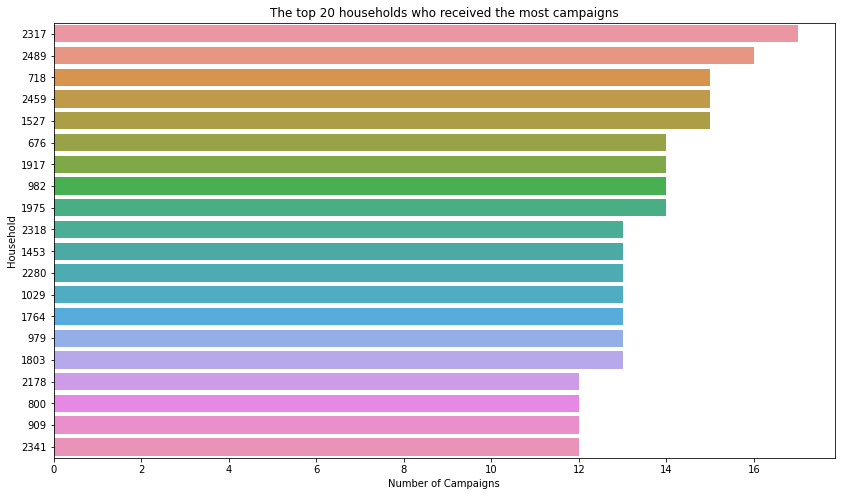

In [150]:
#Which households received the most campaigns - top 20 households
number_of_campaigns_top = number_of_campaigns.head(20)
fig = plt.figure(figsize=(14,8))
sns.barplot(x='Number_of_Campaigns', y='household_key', data=number_of_campaigns_top, orient='h', order=number_of_campaigns_top['household_key'])
plt.title('The top 20 households who received the most campaigns')
plt.xlabel('Number of Campaigns')
plt.ylabel('Household')
plt.show()

# FEATURE CREATION: THE MOST FREQUENTLY RECEIVED CAMPAIGN BY HOUSEHOLD - THREE DUMMY VARIABLES WILL BE CREATED FOR CAMPAIGN TYPES A, B AND C

In [151]:
#Which campaigns were the most frequently received - remember that a household can receive multiple campaign types
#By types, I mean types A, B or C
frequent_campaign_type = pd.DataFrame({'Campaign_Type_Most_Received': campaigns.groupby('household_key')['DESCRIPTION'].agg(pd.Series.mode)})
frequent_campaign_type = frequent_campaign_type.reset_index()
frequent_campaign_type['Campaign_Type_Most_Received'] = frequent_campaign_type['Campaign_Type_Most_Received'].astype(str)

In [152]:
frequent_campaign_type_with_dummies = pd.get_dummies(frequent_campaign_type, columns=['Campaign_Type_Most_Received'])

In [153]:
frequent_campaign_type_with_dummies = frequent_campaign_type_with_dummies[['household_key', 'Campaign_Type_Most_Received_TypeA', 'Campaign_Type_Most_Received_TypeB', 'Campaign_Type_Most_Received_TypeC']]

In [154]:
frequent_campaign_type_with_dummies

,household_key,Campaign_Type_Most_Received_TypeA,Campaign_Type_Most_Received_TypeB,Campaign_Type_Most_Received_TypeC
0,1,0,1,0
1,2,1,0,0
2,3,1,0,0
3,4,1,0,0
4,6,1,0,0
...,...,...,...,...
1579,2496,1,0,0
1580,2497,1,0,0
1581,2498,1,0,0
1582,2499,1,0,0


In [155]:
#Which campaign types were most recieved? 
#Plot the number of times each campaign type was received
#A campaign type (A, B and C) can correspond to multiple campigns numbered from 1 to 30
Count_of_Campaign_Type_By_Household = pd.DataFrame({'Number_of_Times_Campaign_Type_Was_Received': campaigns.groupby('DESCRIPTION')['household_key'].size()})
Count_of_Campaign_Type_By_Household = Count_of_Campaign_Type_By_Household.reset_index()
Count_of_Campaign_Type_By_Household

,DESCRIPTION,Number_of_Times_Campaign_Type_Was_Received
0,TypeA,3979
1,TypeB,2655
2,TypeC,574


In [156]:
Count_of_Campaign_Type_By_Household['Percentage of Receipt'] = (Count_of_Campaign_Type_By_Household['Number_of_Times_Campaign_Type_Was_Received'] / Count_of_Campaign_Type_By_Household['Number_of_Times_Campaign_Type_Was_Received'].sum())*100

In [157]:
Count_of_Campaign_Type_By_Household

,DESCRIPTION,Number_of_Times_Campaign_Type_Was_Received,Percentage of Receipt
0,TypeA,3979,55.202553
1,TypeB,2655,36.834073
2,TypeC,574,7.963374


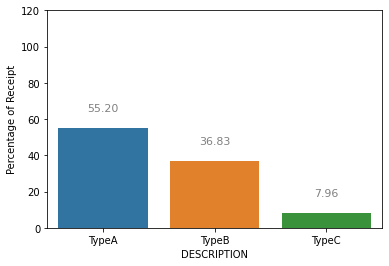

In [158]:
g= sns.barplot(x='DESCRIPTION', y='Percentage of Receipt', data=Count_of_Campaign_Type_By_Household)
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,120)

In [159]:
campaigns['CAMPAIGN'] = campaigns['CAMPAIGN'].astype('str')

In [160]:
#Which individual campaigns were the most recieved? 
#Plot the number of times each campaign was received
Count_of_Campaigns_By_Household = pd.DataFrame({'Number_of_Times_Campaign_Was_Received': campaigns.groupby('CAMPAIGN')['household_key'].count().sort_values(ascending=False)})
Count_of_Campaigns_By_Household = Count_of_Campaigns_By_Household.reset_index()
Count_of_Campaigns_By_Household

,CAMPAIGN,Number_of_Times_Campaign_Was_Received
0,18,1133
1,13,1077
2,8,1076
3,30,361
4,26,332
5,22,276
6,20,244
7,14,224
8,11,214
9,17,202


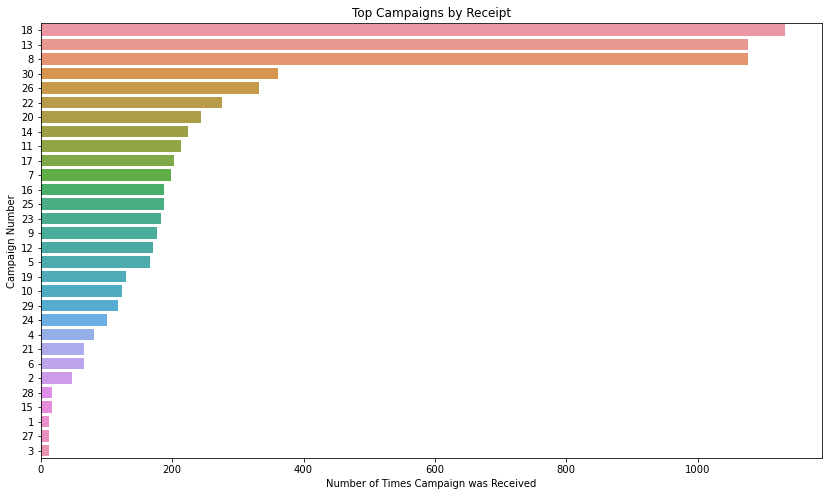

In [161]:
figure = plt.figure(figsize=(14,8))
sns.barplot(y='CAMPAIGN', x='Number_of_Times_Campaign_Was_Received', data=Count_of_Campaigns_By_Household, orient='h')
plt.title('Top Campaigns by Receipt')
plt.xlabel('Number of Times Campaign was Received')
plt.ylabel('Campaign Number')
plt.show()

# INSIGHTS FROM EXISTING VARIABLES IN THE CAMPAIGN DESCRIPTION DATA FILE

In [162]:
#Read in the campaign description file
Campaign_Description = pd.read_csv('campaign_desc.csv')
Campaign_Description

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684
5,TypeB,21,624,656
6,TypeB,22,624,656
7,TypeA,18,587,642
8,TypeB,19,603,635
9,TypeB,17,575,607


# CHECKING THE CAMPAIGN DESCRIPTION DATA FILE FOR MISSING VALUES

In [163]:
print(Campaign_Description.head())
print(Campaign_Description.shape)
print(Campaign_Description.info())
print(Campaign_Description.describe())

  DESCRIPTION  CAMPAIGN  START_DAY  END_DAY
0       TypeB        24        659      719
1       TypeC        15        547      708
2       TypeB        25        659      691
3       TypeC        20        615      685
4       TypeB        23        646      684
(30, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DESCRIPTION  30 non-null     object
 1   CAMPAIGN     30 non-null     int64 
 2   START_DAY    30 non-null     int64 
 3   END_DAY      30 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ KB
None
        CAMPAIGN   START_DAY     END_DAY
count  30.000000   30.000000   30.000000
mean   15.500000  463.866667  510.466667
std     8.803408  134.488490  137.730555
min     1.000000  224.000000  264.000000
25%     8.250000  360.000000  405.750000
50%    15.500000  470.000000  502.000000
75%    22.750000  584.000000  640.2500

In [164]:
#Create a new column called campaign duration
Campaign_Description['Campaign Duration'] = Campaign_Description['END_DAY'] - Campaign_Description['START_DAY']
Campaign_Description['CAMPAIGN'] = Campaign_Description['CAMPAIGN'].astype(str)
Campaign_Description = Campaign_Description

In [165]:
Campaign_Description

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,Campaign Duration
0,TypeB,24,659,719,60
1,TypeC,15,547,708,161
2,TypeB,25,659,691,32
3,TypeC,20,615,685,70
4,TypeB,23,646,684,38
5,TypeB,21,624,656,32
6,TypeB,22,624,656,32
7,TypeA,18,587,642,55
8,TypeB,19,603,635,32
9,TypeB,17,575,607,32


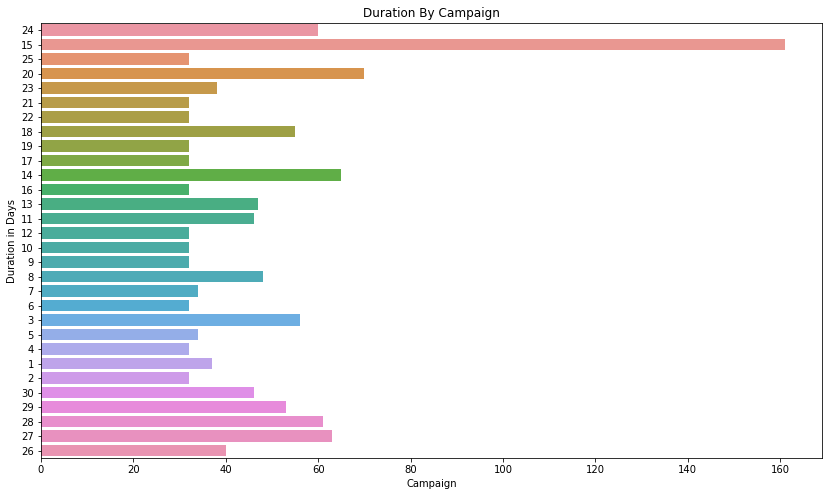

In [166]:
fig = plt.figure(figsize=(14,8))
sns.barplot(x='Campaign Duration', y='CAMPAIGN', data=Campaign_Description)
plt.title('Duration By Campaign')
plt.xlabel('Campaign')
plt.ylabel('Duration in Days')
plt.show()

In [167]:
Campaign_Type_Avg_Duration = pd.DataFrame({'Average_Duration':Campaign_Description.groupby('DESCRIPTION')['Campaign Duration'].mean()})
Campaign_Type_Avg_Duration = Campaign_Type_Avg_Duration.reset_index()
Campaign_Type_Avg_Duration

,DESCRIPTION,Average_Duration
0,TypeA,47.200000
1,TypeB,37.631579
2,TypeC,74.500000


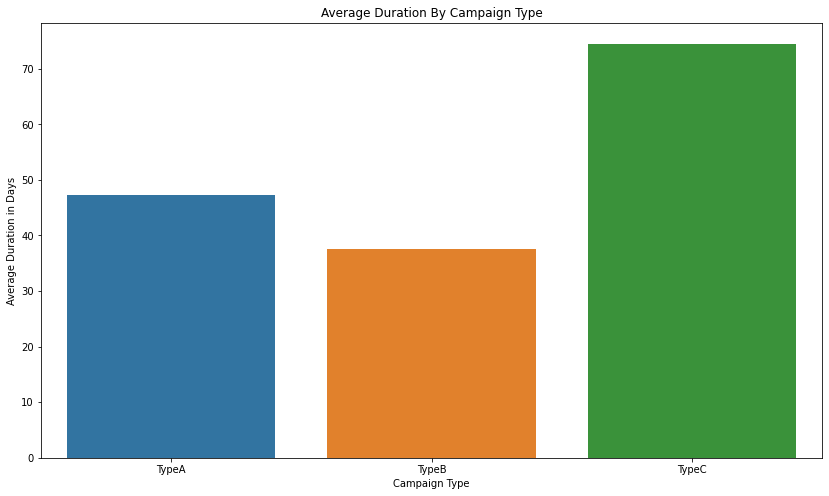

In [168]:
fig = plt.figure(figsize=(14,8))
sns.barplot(x='DESCRIPTION', y='Average_Duration', data=Campaign_Type_Avg_Duration, order=Campaign_Type_Avg_Duration['DESCRIPTION'])
plt.title('Average Duration By Campaign Type')
plt.xlabel('Campaign Type')
plt.ylabel('Average Duration in Days')
plt.show()

# INSIGHTS FROM EXISTING VARIABLES IN THE COUPON FILE

In [169]:
#Read in the coupon file - this pertains to coupons issued by campaign
Coupon = pd.read_csv('coupon.csv')
Coupon

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25
...,...,...,...
124543,10000085478,13038802,18
124544,10000085479,13039368,18
124545,10000085478,13039553,18
124546,10000085479,13776332,18


# CHECKING THE COUPON FILE FOR MISSING VALUES

In [170]:
print(Coupon.head())
print(Coupon.shape)
print(Coupon.info())
print(Coupon.describe())

    COUPON_UPC  PRODUCT_ID  CAMPAIGN
0  10000089061       27160         4
1  10000089064       27754         9
2  10000089073       28897        12
3  51800009050       28919        28
4  52100000076       28929        25
(124548, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124548 entries, 0 to 124547
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   COUPON_UPC  124548 non-null  int64
 1   PRODUCT_ID  124548 non-null  int64
 2   CAMPAIGN    124548 non-null  int64
dtypes: int64(3)
memory usage: 2.9 MB
None
         COUPON_UPC    PRODUCT_ID       CAMPAIGN
count  1.245480e+05  1.245480e+05  124548.000000
mean   2.198225e+10  4.651277e+06      15.855935
std    1.961641e+10  4.843450e+06       6.015524
min    1.000009e+10  2.567100e+04       1.000000
25%    1.000009e+10  9.593030e+05      13.000000
50%    1.000009e+10  1.411451e+06      14.000000
75%    5.111108e+10  8.357538e+06      18.000000
max    5.998660e+10  

# DESCRIPTIVE STATISTICS FROM THE COUPON FILE

In [171]:
Coupon['PRODUCT_ID'].nunique()

44133

In [172]:
Coupon['COUPON_UPC'].nunique()

1135

In [173]:
Coupon['CAMPAIGN'].nunique()

30

In [174]:
#Top campaigns by number of coupons issued
#Note that a coupon with the same UPC code can be issued across multiple products across a campaign
Coupon_Issue_by_Campaign = pd.DataFrame({'Number of Coupons Issued by Campaign': Coupon.groupby('CAMPAIGN')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Issue_by_Campaign = Coupon_Issue_by_Campaign.reset_index()
Coupon_Issue_by_Campaign

,CAMPAIGN,Number of Coupons Issued by Campaign
0,13,38248
1,18,37589
2,8,19206
3,27,4322
4,30,4106
5,24,3774
6,26,3744
7,22,1917
8,14,1062
9,16,1025


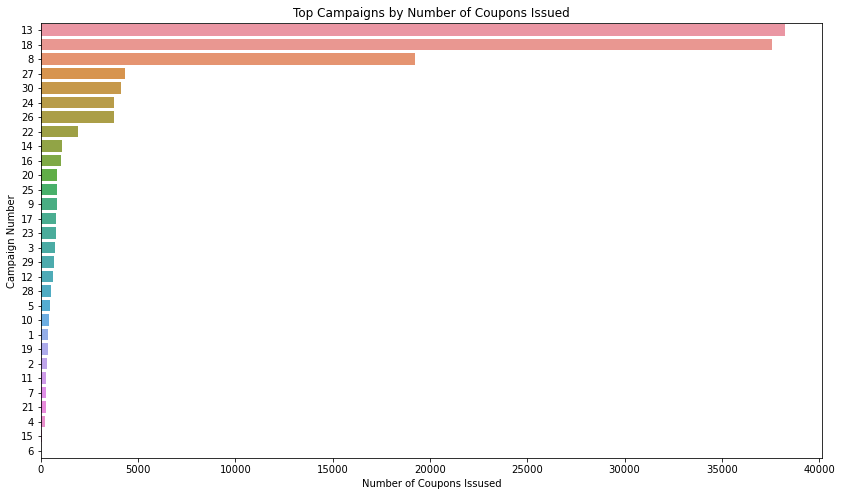

In [175]:
figure = plt.figure(figsize=(14,8))
sns.barplot(y='CAMPAIGN', x='Number of Coupons Issued by Campaign', data=Coupon_Issue_by_Campaign, order=Coupon_Issue_by_Campaign['CAMPAIGN'],orient='h')
plt.title('Top Campaigns by Number of Coupons Issued')
plt.xlabel('Number of Coupons Issused')
plt.ylabel('Campaign Number')
plt.show()

# INSIGHTS DERIVED FROM MERGING THE COUPON FILE WITH THE PRODUCTS FILE

In [176]:
product_coupon = pd.merge(Coupon, products, on='PRODUCT_ID', how='left')
product_coupon

,COUPON_UPC,PRODUCT_ID,CAMPAIGN,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,Item Indicator
0,10000089061,27160,4,69,GROCERY,Private,SHORTENING/OIL,VEGETABLE/SALAD OIL,48 OZ,ORDINARY ITEM
1,10000089064,27754,9,69,GROCERY,Private,FRZN VEGETABLE/VEG DSH,FRZN BAGGED VEGETABLES - PLAIN,16 OZ,ORDINARY ITEM
2,10000089073,28897,12,69,GROCERY,Private,EGGS,EGGS - X-LARGE,A D 1 DZ,ORDINARY ITEM
3,51800009050,28919,28,236,GROCERY,National,REFRGRATD DOUGH PRODUCTS,REFRIGERATED COOKIES-CHUB,16.5 OZ,ORDINARY ITEM
4,52100000076,28929,25,317,GROCERY,National,CHEESE,STRING CHEESE,AB 8 OZ,ORDINARY ITEM
...,...,...,...,...,...,...,...,...,...,...
124543,10000085478,13038802,18,1119,DRUG GM,National,AUDIO/VIDEO PRODUCTS,PARFUMS DE COUER,,ORDINARY ITEM
124544,10000085479,13039368,18,2875,MEAT,National,BEEF,CHOICE BEEF,,ORDINARY ITEM
124545,10000085478,13039553,18,1229,DRUG GM,National,STATIONERY & SCHOOL SUPPLIES,BONNE BELL,,ORDINARY ITEM
124546,10000085479,13776332,18,4824,MEAT,National,SMOKED MEATS,HAMS-HALF/PORT BONELESS,,ORDINARY ITEM


In [177]:
#Top Product Categories by number of coupons issued
#Note that a coupon with the same UPC code can be issued across multiple products across a campaign
Coupon_Issue_by_Product_Category = pd.DataFrame({'Number of Coupons Issued by Product Category': product_coupon.groupby('DEPARTMENT')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Issue_by_Product_Category = Coupon_Issue_by_Product_Category.reset_index()
Coupon_Issue_by_Product_Category

,DEPARTMENT,Number of Coupons Issued by Product Category
0,GROCERY,51507
1,DRUG GM,33780
2,PRODUCE,8276
3,MEAT,7548
4,MEAT-PCKGD,7547
5,COSMETICS,6618
6,FLORAL,2673
7,NUTRITION,2281
8,SEAFOOD-PCKGD,2192
9,SEAFOOD,751


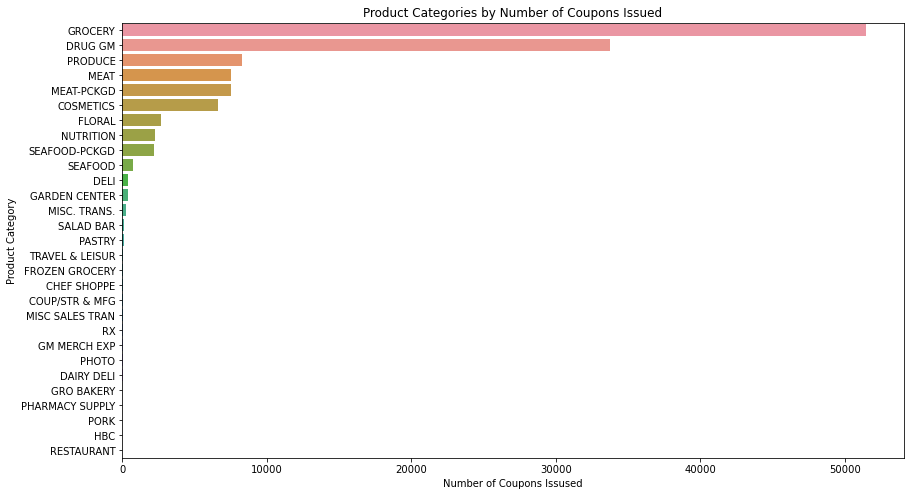

In [178]:
figure = plt.figure(figsize=(14,8))
sns.barplot(y='DEPARTMENT', x='Number of Coupons Issued by Product Category', data=Coupon_Issue_by_Product_Category, order=Coupon_Issue_by_Product_Category['DEPARTMENT'],orient='h')
plt.title('Product Categories by Number of Coupons Issued')
plt.xlabel('Number of Coupons Issused')
plt.ylabel('Product Category')
plt.show()

In [179]:
product_coupon

,COUPON_UPC,PRODUCT_ID,CAMPAIGN,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,Item Indicator
0,10000089061,27160,4,69,GROCERY,Private,SHORTENING/OIL,VEGETABLE/SALAD OIL,48 OZ,ORDINARY ITEM
1,10000089064,27754,9,69,GROCERY,Private,FRZN VEGETABLE/VEG DSH,FRZN BAGGED VEGETABLES - PLAIN,16 OZ,ORDINARY ITEM
2,10000089073,28897,12,69,GROCERY,Private,EGGS,EGGS - X-LARGE,A D 1 DZ,ORDINARY ITEM
3,51800009050,28919,28,236,GROCERY,National,REFRGRATD DOUGH PRODUCTS,REFRIGERATED COOKIES-CHUB,16.5 OZ,ORDINARY ITEM
4,52100000076,28929,25,317,GROCERY,National,CHEESE,STRING CHEESE,AB 8 OZ,ORDINARY ITEM
...,...,...,...,...,...,...,...,...,...,...
124543,10000085478,13038802,18,1119,DRUG GM,National,AUDIO/VIDEO PRODUCTS,PARFUMS DE COUER,,ORDINARY ITEM
124544,10000085479,13039368,18,2875,MEAT,National,BEEF,CHOICE BEEF,,ORDINARY ITEM
124545,10000085478,13039553,18,1229,DRUG GM,National,STATIONERY & SCHOOL SUPPLIES,BONNE BELL,,ORDINARY ITEM
124546,10000085479,13776332,18,4824,MEAT,National,SMOKED MEATS,HAMS-HALF/PORT BONELESS,,ORDINARY ITEM


In [180]:
#Filter by top 5 campaigns and bottom 5 campaigns to see what kinds of campaigns these were in terms of coupon distribution across product categories
top_5_campaigns = product_coupon[(product_coupon['CAMPAIGN']==18)|(product_coupon['CAMPAIGN']==13)|(product_coupon['CAMPAIGN']==8)|(product_coupon['CAMPAIGN']==26)|(product_coupon['CAMPAIGN']==30)]
bottom_5_campaigns = product_coupon[(product_coupon['CAMPAIGN']==1)|(product_coupon['CAMPAIGN']==28)|(product_coupon['CAMPAIGN']==27)|(product_coupon['CAMPAIGN']==6)|(product_coupon['CAMPAIGN']==15)]

In [181]:
Coupon_Issue_by_Top_Campaigns = pd.DataFrame({'Number of Coupons Issued Across Product Categories by Top Campaigns': top_5_campaigns.groupby('DEPARTMENT')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Issue_by_Top_Campaigns = Coupon_Issue_by_Top_Campaigns.reset_index()
Coupon_Issue_by_Top_Campaigns

,DEPARTMENT,Number of Coupons Issued Across Product Categories by Top Campaigns
0,GROCERY,38364
1,DRUG GM,26749
2,PRODUCE,8234
3,MEAT,7548
4,MEAT-PCKGD,7420
5,COSMETICS,5833
6,FLORAL,2673
7,SEAFOOD-PCKGD,2073
8,NUTRITION,1925
9,SEAFOOD,751


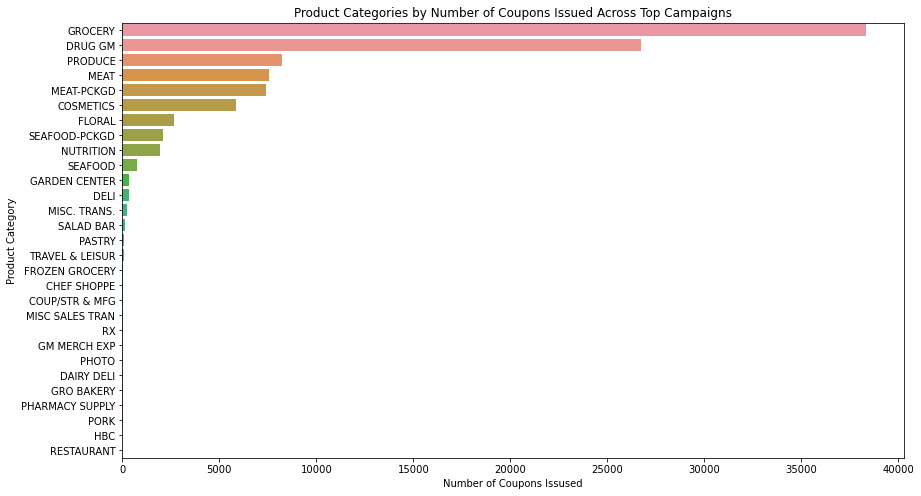

In [182]:
figure = plt.figure(figsize=(14,8))
sns.barplot(y='DEPARTMENT', x='Number of Coupons Issued Across Product Categories by Top Campaigns', data=Coupon_Issue_by_Top_Campaigns, order=Coupon_Issue_by_Top_Campaigns['DEPARTMENT'],orient='h')
plt.title('Product Categories by Number of Coupons Issued Across Top Campaigns')
plt.xlabel('Number of Coupons Issused')
plt.ylabel('Product Category')
plt.show()

In [183]:
Coupon_Issue_by_Top_Campaigns_Desc = pd.DataFrame({'Number of Coupons Issued Across Product Sub-categories by Top Campaigns': top_5_campaigns.groupby('COMMODITY_DESC')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Issue_by_Top_Campaigns_Desc = Coupon_Issue_by_Top_Campaigns_Desc.reset_index()
Coupon_Issue_by_Top_Campaigns_Desc

,COMMODITY_DESC,Number of Coupons Issued Across Product Sub-categories by Top Campaigns
0,MAKEUP AND TREATMENT,4807
1,FRZN MEAT/MEAT DINNERS,4307
2,HAIR CARE PRODUCTS,3995
3,BEEF,3314
4,FROZEN PIZZA,3256
...,...,...
258,NATURAL HBC,2
259,TICKETS,1
260,BOOKSTORE,1
261,BEVERAGE,1


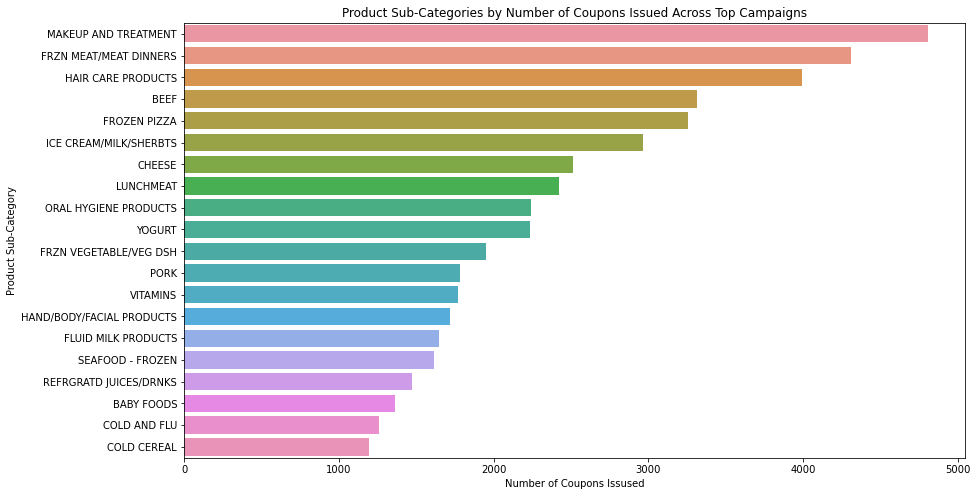

In [184]:
Coupon_Issue_by_Top_Campaigns_Desc = Coupon_Issue_by_Top_Campaigns_Desc.head(20)
figure = plt.figure(figsize=(14,8))
sns.barplot(y='COMMODITY_DESC', x='Number of Coupons Issued Across Product Sub-categories by Top Campaigns', data=Coupon_Issue_by_Top_Campaigns_Desc, order=Coupon_Issue_by_Top_Campaigns_Desc['COMMODITY_DESC'],orient='h')
plt.title('Product Sub-Categories by Number of Coupons Issued Across Top Campaigns')
plt.xlabel('Number of Coupons Issused')
plt.ylabel('Product Sub-Category')
plt.show()

In [185]:
Coupon_Issue_by_Bottom_Campaigns = pd.DataFrame({'Number of Coupons Issued Across Product Categories by Bottom Campaigns': bottom_5_campaigns.groupby('DEPARTMENT')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Issue_by_Bottom_Campaigns = Coupon_Issue_by_Bottom_Campaigns.reset_index()
Coupon_Issue_by_Bottom_Campaigns

,DEPARTMENT,Number of Coupons Issued Across Product Categories by Bottom Campaigns
0,GROCERY,3023
1,DRUG GM,2284
2,COUP/STR & MFG,6


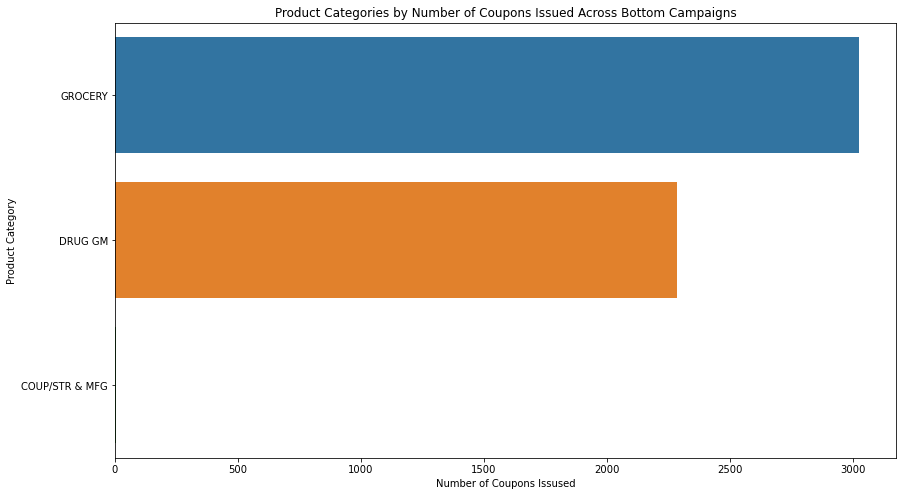

In [186]:
figure = plt.figure(figsize=(14,8))
sns.barplot(y='DEPARTMENT', x='Number of Coupons Issued Across Product Categories by Bottom Campaigns', data=Coupon_Issue_by_Bottom_Campaigns, order=Coupon_Issue_by_Bottom_Campaigns['DEPARTMENT'],orient='h')
plt.title('Product Categories by Number of Coupons Issued Across Bottom Campaigns')
plt.xlabel('Number of Coupons Issused')
plt.ylabel('Product Category')
plt.show()

In [187]:
Coupon_Issue_by_Bottom_Campaigns_Desc = pd.DataFrame({'Number of Coupons Issued Across Product Sub-categories by Bottom Campaigns': bottom_5_campaigns.groupby('COMMODITY_DESC')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Issue_by_Bottom_Campaigns_Desc = Coupon_Issue_by_Bottom_Campaigns_Desc.reset_index()
Coupon_Issue_by_Bottom_Campaigns_Desc

,COMMODITY_DESC,Number of Coupons Issued Across Product Sub-categories by Bottom Campaigns
0,HAIR CARE PRODUCTS,1590
1,DRY BN/VEG/POTATO/RICE,511
2,DEODORANTS,352
3,PASTA SAUCE,348
4,LAUNDRY DETERGENTS,300
5,SALD DRSNG/SNDWCH SPRD,297
6,SOAP - LIQUID & BAR,286
7,CHEESE,253
8,TEAS,227
9,LAUNDRY ADDITIVES,200


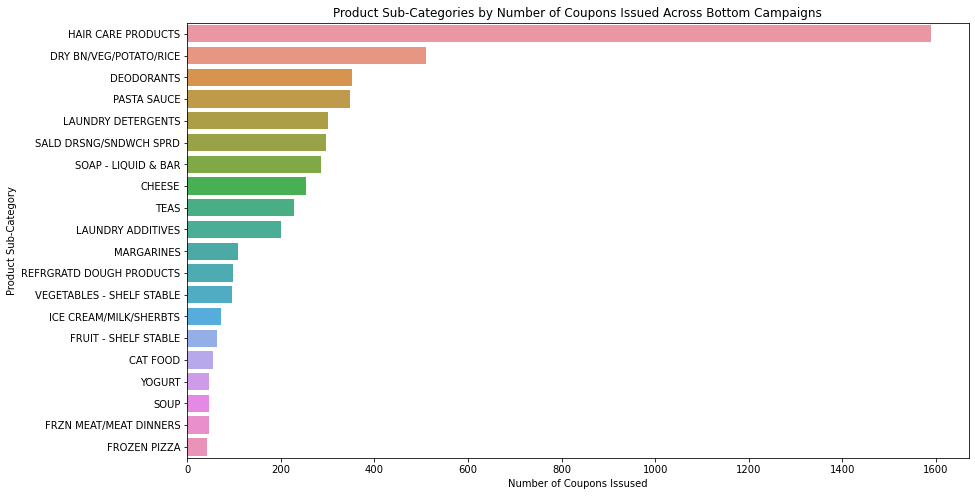

In [188]:
Coupon_Issue_by_Bottom_Campaigns_Desc = Coupon_Issue_by_Bottom_Campaigns_Desc.head(20)
figure = plt.figure(figsize=(14,8))
sns.barplot(y='COMMODITY_DESC', x='Number of Coupons Issued Across Product Sub-categories by Bottom Campaigns', data=Coupon_Issue_by_Bottom_Campaigns_Desc, order=Coupon_Issue_by_Bottom_Campaigns_Desc['COMMODITY_DESC'],orient='h')
plt.title('Product Sub-Categories by Number of Coupons Issued Across Bottom Campaigns')
plt.xlabel('Number of Coupons Issused')
plt.ylabel('Product Sub-Category')
plt.show()

In [189]:
Campaign_Description['CAMPAIGN']= Campaign_Description['CAMPAIGN'].astype('float64')

In [190]:
#Merge the campaign_description data frame with the product_coupon data frame
product_coupon_campaign_type = pd.merge(product_coupon, Campaign_Description, on='CAMPAIGN', how='left')

In [191]:
#Filter by campaign types to see what kinds of campaigns these were in terms of coupon distribution across product categories
type_a = product_coupon_campaign_type[product_coupon_campaign_type['DESCRIPTION']=="TypeA"]
type_b = product_coupon_campaign_type[product_coupon_campaign_type['DESCRIPTION']=="TypeB"]
type_c = product_coupon_campaign_type[product_coupon_campaign_type['DESCRIPTION']=="TypeC"]

In [192]:
Coupon_Issue_by_TypeA = pd.DataFrame({'Number of Coupons Issued Across Product Categories': type_a.groupby('DEPARTMENT')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Issue_by_TypeA = Coupon_Issue_by_TypeA.reset_index()
Coupon_Issue_by_TypeA

,DEPARTMENT,Number of Coupons Issued Across Product Categories
0,GROCERY,38364
1,DRUG GM,26749
2,PRODUCE,8234
3,MEAT,7548
4,MEAT-PCKGD,7420
5,COSMETICS,5833
6,FLORAL,2673
7,SEAFOOD-PCKGD,2073
8,NUTRITION,1925
9,SEAFOOD,751


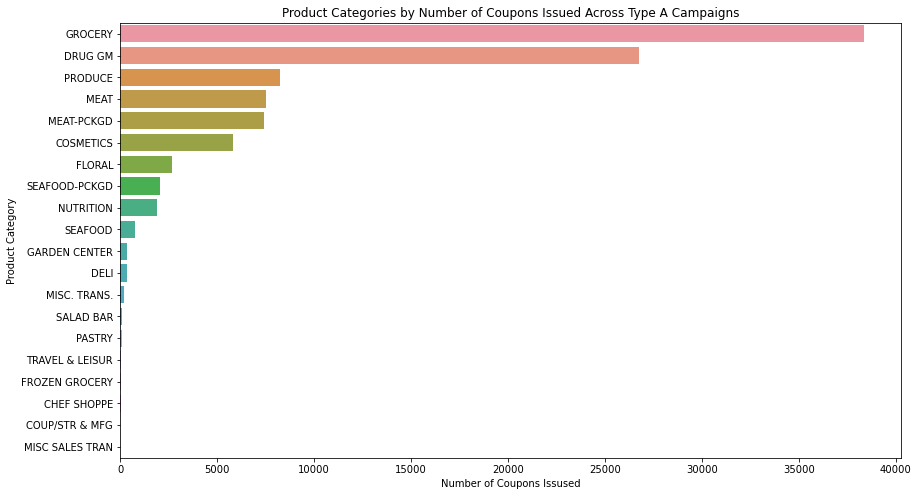

In [193]:
Coupon_Issue_by_TypeA = Coupon_Issue_by_TypeA.head(20)
figure = plt.figure(figsize=(14,8))
sns.barplot(y='DEPARTMENT', x='Number of Coupons Issued Across Product Categories', data=Coupon_Issue_by_TypeA, order=Coupon_Issue_by_TypeA['DEPARTMENT'],orient='h')
plt.title('Product Categories by Number of Coupons Issued Across Type A Campaigns')
plt.xlabel('Number of Coupons Issused')
plt.ylabel('Product Category')
plt.show()

In [194]:
Coupon_Issue_by_TypeB = pd.DataFrame({'Number of Coupons Issued Across Product Categories': type_b.groupby('DEPARTMENT')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Issue_by_TypeB = Coupon_Issue_by_TypeB.reset_index()
Coupon_Issue_by_TypeB

,DEPARTMENT,Number of Coupons Issued Across Product Categories
0,GROCERY,9808
1,DRUG GM,3348
2,COSMETICS,779
3,NUTRITION,355
4,MEAT-PCKGD,124
5,SEAFOOD-PCKGD,119
6,PRODUCE,42
7,DELI,17
8,PASTRY,16
9,MISC. TRANS.,8


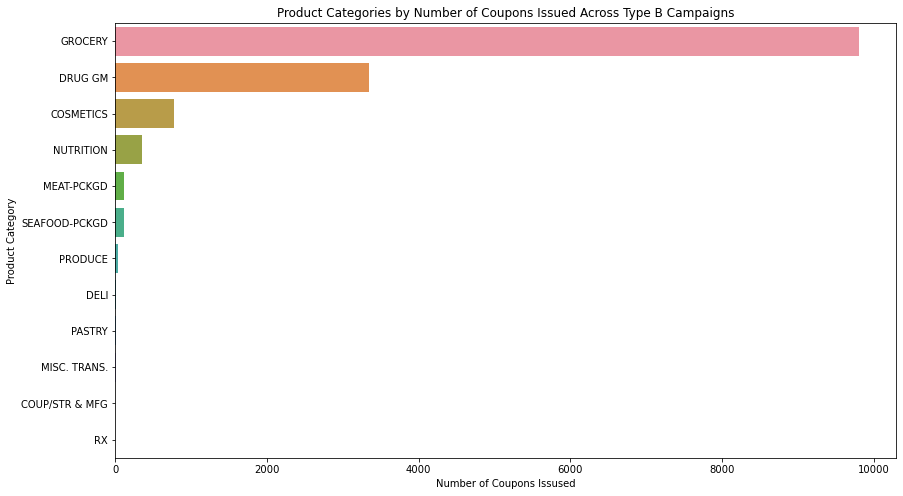

In [195]:
Coupon_Issue_by_TypeB = Coupon_Issue_by_TypeB.head(20)
figure = plt.figure(figsize=(14,8))
sns.barplot(y='DEPARTMENT', x='Number of Coupons Issued Across Product Categories', data=Coupon_Issue_by_TypeB, order=Coupon_Issue_by_TypeB['DEPARTMENT'],orient='h')
plt.title('Product Categories by Number of Coupons Issued Across Type B Campaigns')
plt.xlabel('Number of Coupons Issused')
plt.ylabel('Product Category')
plt.show()

In [196]:
Coupon_Issue_by_TypeC = pd.DataFrame({'Number of Coupons Issued Across Product Categories': type_c.groupby('DEPARTMENT')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Issue_by_TypeC = Coupon_Issue_by_TypeC.reset_index()
Coupon_Issue_by_TypeC

,DEPARTMENT,Number of Coupons Issued Across Product Categories
0,DRUG GM,3683
1,GROCERY,3335
2,COUP/STR & MFG,6
3,COSMETICS,6
4,MEAT-PCKGD,3
5,NUTRITION,1


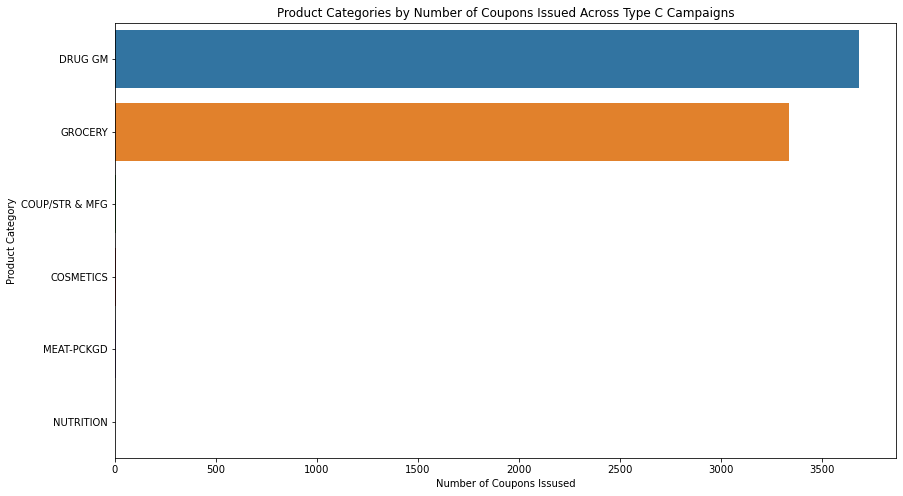

In [197]:
Coupon_Issue_by_TypeC = Coupon_Issue_by_TypeC.head(20)
figure = plt.figure(figsize=(14,8))
sns.barplot(y='DEPARTMENT', x='Number of Coupons Issued Across Product Categories', data=Coupon_Issue_by_TypeC, order=Coupon_Issue_by_TypeC['DEPARTMENT'],orient='h')
plt.title('Product Categories by Number of Coupons Issued Across Type C Campaigns')
plt.xlabel('Number of Coupons Issused')
plt.ylabel('Product Category')
plt.show()

# INSIGHTS DERIVED FROM MERGING THE COUPON FILE WITH THE CAMPAIGN DESCRIPTION FILE

In [198]:
Coupon['CAMPAIGN'] = Coupon['CAMPAIGN'].astype('float64')

In [199]:
campaign_desc_coupon = pd.merge(Coupon, Campaign_Description, on='CAMPAIGN', how='left')
campaign_desc_coupon

,COUPON_UPC,PRODUCT_ID,CAMPAIGN,DESCRIPTION,START_DAY,END_DAY,Campaign Duration
0,10000089061,27160,4.0,TypeB,372,404,32
1,10000089064,27754,9.0,TypeB,435,467,32
2,10000089073,28897,12.0,TypeB,477,509,32
3,51800009050,28919,28.0,TypeB,259,320,61
4,52100000076,28929,25.0,TypeB,659,691,32
...,...,...,...,...,...,...,...
124543,10000085478,13038802,18.0,TypeA,587,642,55
124544,10000085479,13039368,18.0,TypeA,587,642,55
124545,10000085478,13039553,18.0,TypeA,587,642,55
124546,10000085479,13776332,18.0,TypeA,587,642,55


In [200]:
#Top Product Categories by number of coupons issued
#Note that a coupon with the same UPC code can be issued across multiple products across a campaign
Coupon_Issue_by_Campaign_Type = pd.DataFrame({'Number of Coupons Issued by Campaign Type': campaign_desc_coupon.groupby('DESCRIPTION')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Issue_by_Campaign_Type = Coupon_Issue_by_Campaign_Type.reset_index()
Coupon_Issue_by_Campaign_Type

,DESCRIPTION,Number of Coupons Issued by Campaign Type
0,TypeA,102893
1,TypeB,14621
2,TypeC,7034


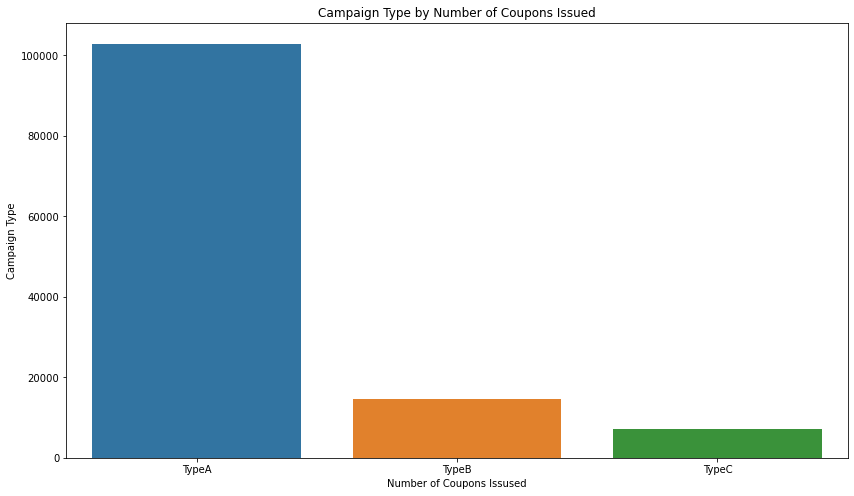

In [201]:
figure = plt.figure(figsize=(14,8))
sns.barplot(y='Number of Coupons Issued by Campaign Type', x='DESCRIPTION', data=Coupon_Issue_by_Campaign_Type, order=Coupon_Issue_by_Campaign_Type['DESCRIPTION'])
plt.title('Campaign Type by Number of Coupons Issued')
plt.xlabel('Number of Coupons Issused')
plt.ylabel('Campaign Type')
plt.show()

# INSIGHTS DERIVED FROM EXISTING VARIABLES IN THE COUPON REDEMPTION FILE

In [202]:
#Read in the coupon redemption file
Coupon_Redemption = pd.read_csv('coupon_redempt.csv')
Coupon_Redemption

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18
...,...,...,...,...
2313,2496,592,54900050076,18
2314,2496,610,55100000013,18
2315,2500,449,53663200076,8
2316,2500,449,54300031076,8


# CHECKING FOR MISSING VALUES IN THE COUPON REDEMPTION FILE

In [203]:
print(Coupon_Redemption.head())
print(Coupon_Redemption.shape)
print(Coupon_Redemption.info())
print(Coupon_Redemption.describe())

   household_key  DAY   COUPON_UPC  CAMPAIGN
0              1  421  10000085364         8
1              1  421  51700010076         8
2              1  427  54200000033         8
3              1  597  10000085476        18
4              1  597  54200029176        18
(2318, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   household_key  2318 non-null   int64
 1   DAY            2318 non-null   int64
 2   COUPON_UPC     2318 non-null   int64
 3   CAMPAIGN       2318 non-null   int64
dtypes: int64(4)
memory usage: 72.6 KB
None
       household_key          DAY    COUPON_UPC     CAMPAIGN
count    2318.000000  2318.000000  2.318000e+03  2318.000000
mean     1302.816652   528.217429  4.123049e+10    15.551337
std       783.002545   100.360985  1.986068e+10     5.716636
min         1.000000   225.000000  1.000009e+10     1.000000
25%       588

In [204]:
#Convert the COUPON_UPC column into a string column
Coupon_Redemption['COUPON_UPC'] = Coupon_Redemption['COUPON_UPC'].astype(str)

In [205]:
#How many unqiue households redeemed coupons? - including product ids that corresponded to the coupons category
Coupon_Redemption['household_key'].nunique()

434

In [206]:
#How many unqiue coupons were redeemed?
Coupon_Redemption['COUPON_UPC'].nunique()

556

# FEATURE CREATION: NUMBER OF COUPON REDEMPTIONS PER HOUSEHOLD

In [207]:
#Calculate the number of redemptions per household
#First convert the COUPON_UPC into a string
Redemption_By_Household = pd.DataFrame({'Number_of_Coupons_Redeemed_By_Household': Coupon_Redemption.groupby('household_key')['COUPON_UPC'].count().sort_values(ascending=False)})
Redemption_By_Household = Redemption_By_Household.reset_index()
Redemption_By_Household_For_Modelling = Redemption_By_Household
Redemption_By_Household.head(20)

,household_key,Number_of_Coupons_Redeemed_By_Household
0,367,35
1,256,33
2,67,33
3,1823,30
4,931,29
5,2489,28
6,1591,28
7,979,28
8,1726,27
9,22,25


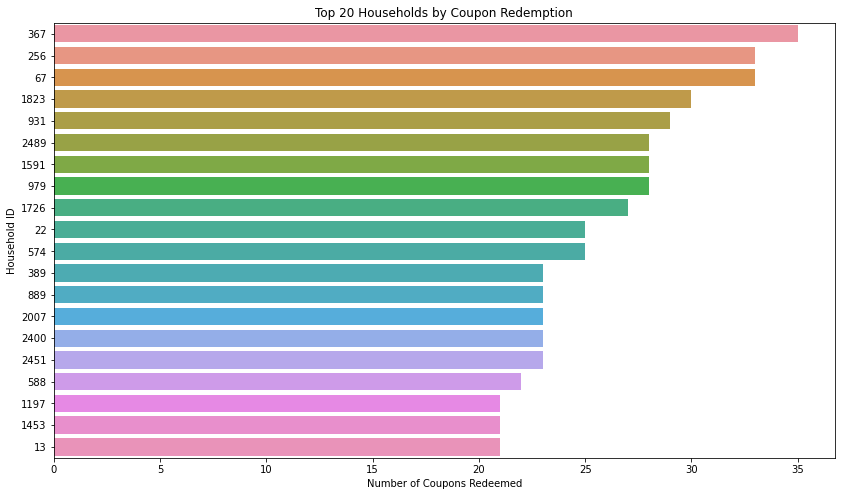

In [208]:
Redemption_By_Household = Redemption_By_Household.head(20)
Redemption_By_Household
figure = plt.figure(figsize=(14,8))
sns.barplot(y='household_key', x='Number_of_Coupons_Redeemed_By_Household', data=Redemption_By_Household, orient='h', order=Redemption_By_Household['household_key'])
plt.title('Top 20 Households by Coupon Redemption')
plt.xlabel('Number of Coupons Redeemed')
plt.ylabel('Household ID')
plt.show()

In [209]:
#Top 20 campaigns by coupon redemption 
Coupon_Redemptions_by_Campaign = pd.DataFrame({'Number of Coupons Redeemed by Campaign': Coupon_Redemption.groupby('CAMPAIGN')['COUPON_UPC'].count().sort_values(ascending=False)})
Coupon_Redemptions_by_Campaign = Coupon_Redemptions_by_Campaign.reset_index()
Coupon_Redemptions_by_Campaign

,CAMPAIGN,Number of Coupons Redeemed by Campaign
0,18,653
1,13,629
2,8,372
3,26,73
4,30,64
5,25,61
6,23,60
7,22,47
8,17,45
9,9,43


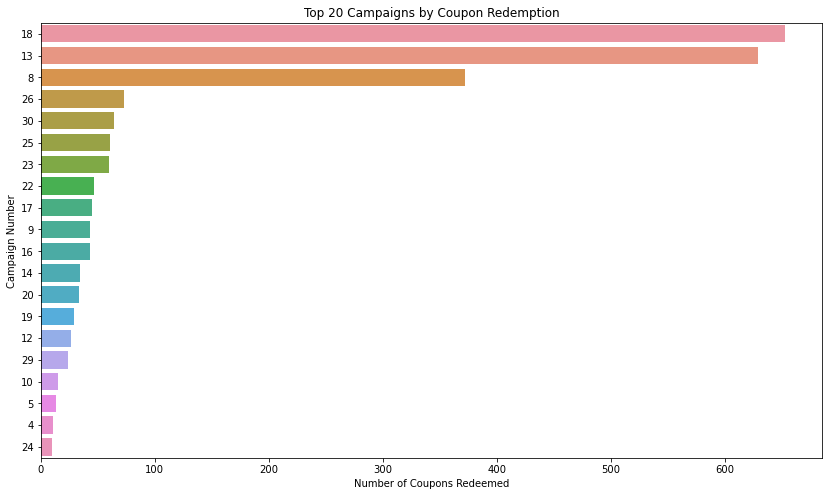

In [210]:
Coupon_Redemptions_by_Campaign = Coupon_Redemptions_by_Campaign.head(20)
figure = plt.figure(figsize=(14,8))
sns.barplot(x='Number of Coupons Redeemed by Campaign', y='CAMPAIGN', data=Coupon_Redemptions_by_Campaign, orient='h', order=Coupon_Redemptions_by_Campaign['CAMPAIGN'])
plt.title('Top 20 Campaigns by Coupon Redemption')
plt.xlabel('Number of Coupons Redeemed')
plt.ylabel('Campaign Number')
plt.show()

In [211]:
#Bottom 20 campaigns by coupon redemption 
Coupon_Redemptions_by_Campaign = pd.DataFrame({'Number of Coupons Redeemed by Campaign': Coupon_Redemption.groupby('CAMPAIGN')['COUPON_UPC'].count().sort_values(ascending=True)})
Coupon_Redemptions_by_Campaign = Coupon_Redemptions_by_Campaign.reset_index()
Coupon_Redemptions_by_Campaign

,CAMPAIGN,Number of Coupons Redeemed by Campaign
0,1,1
1,28,1
2,27,1
3,6,1
4,15,2
5,3,2
6,2,5
7,21,5
8,7,7
9,11,8


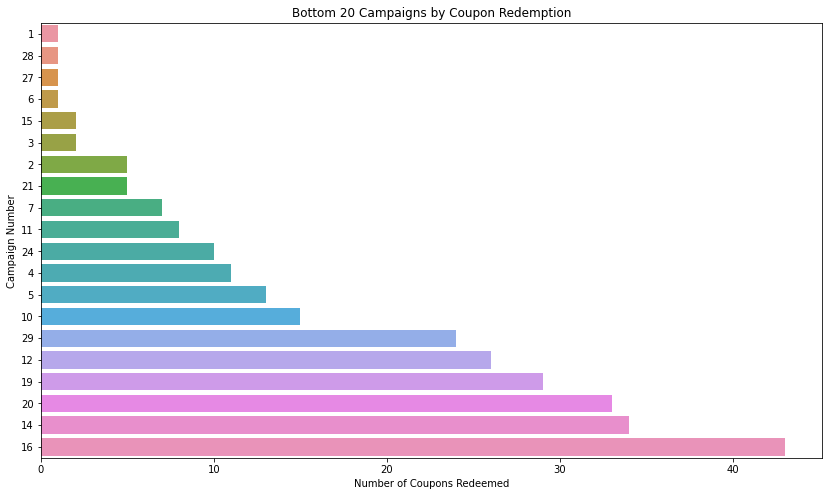

In [212]:
Coupon_Redemptions_by_Campaign = Coupon_Redemptions_by_Campaign.head(20)
figure = plt.figure(figsize=(14,8))
sns.barplot(x='Number of Coupons Redeemed by Campaign', y='CAMPAIGN', data=Coupon_Redemptions_by_Campaign, orient='h', order=Coupon_Redemptions_by_Campaign['CAMPAIGN'])
plt.title('Bottom 20 Campaigns by Coupon Redemption')
plt.xlabel('Number of Coupons Redeemed')
plt.ylabel('Campaign Number')
plt.show()

# CORRELATION ANALYSIS - THE REMOVAL OF REDUNDANT INDEPENDENT VARIABLES ONLY IF CORRELATION IMPLIES CAUSATION

In [213]:
#Correlation analysis to find redundant variables will be carried out only for the variables created from the Campaign Table Data file. 

In [214]:
#Recall that the data frame frequent_campaign_type_with_dummies contained dummy variables for each campaign type - A, B and C
#The data frame campaign_dummies contained dummy variables for each of the 30 campaigns

# To avoid crowding of the correlation matrix, the correlation analysis will have to be consolidated into multiple correlation matrices so that the correlation coefficients are easy to read and understand.

In [215]:
#Correlation of all campaign dummies

In [216]:
corrs = campaign_dummies.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapscampaigns.html')

'corrheatmapscampaigns.html'

In [217]:
#Correlation of all campaign type dummies

In [218]:
#Correlation of campiagn type dummies
#Remove redundant variables if applicable
#Examine correlation matrix
corrs = frequent_campaign_type_with_dummies.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapscampaigntypes.html')

'corrheatmapscampaigntypes.html'

In [219]:
#Correlation of campaign type A dummy with all 30 campaign dummies
type_A = frequent_campaign_type_with_dummies[['Campaign_Type_Most_Received_TypeA', 'household_key']]

In [220]:
type_A_with_campaign_dummies = pd.merge(type_A, campaign_dummies, on='household_key')

In [221]:
corrs = type_A_with_campaign_dummies.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapscampaigntypeAwithcampaigndummies.html')

'corrheatmapscampaigntypeAwithcampaigndummies.html'

In [222]:
#Correlation of campaign type B dummy with all 30 campaign dummies
type_B = frequent_campaign_type_with_dummies[['Campaign_Type_Most_Received_TypeB', 'household_key']]

In [223]:
type_B_with_campaign_dummies = pd.merge(type_B, campaign_dummies, on='household_key')

In [224]:
corrs = type_B_with_campaign_dummies.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapscampaigntypeBwithcampaigndummies.html')

'corrheatmapscampaigntypeBwithcampaigndummies.html'

In [225]:
#Correlation of campaign type C dummy with all 30 campaign dummies
type_C = frequent_campaign_type_with_dummies[['Campaign_Type_Most_Received_TypeC', 'household_key']]

In [226]:
type_C_with_campaign_dummies = pd.merge(type_C, campaign_dummies, on='household_key')

In [227]:
corrs = type_C_with_campaign_dummies.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapscampaigntypeCwithcampaigndummies.html')

'corrheatmapscampaigntypeCwithcampaigndummies.html'

In [228]:
#Merging the RFM data frame with campaign_dummies
rfm_campaign = pd.merge(RFM_Recency_Frequency_Monetary, campaign_dummies, on='household_key', how='left')
rfm_campaign['Recency Score'] = rfm_campaign['Recency Score'].astype('float64')
rfm_campaign['Frequency Score'] = rfm_campaign['Frequency Score'].astype('float64')
rfm_campaign['Monetary Score'] = rfm_campaign['Monetary Score'].astype('float64')
rfm_campaign = rfm_campaign.fillna(0)

In [229]:
corrs = rfm_campaign.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapsrfmwithcampaigndummies.html')

'corrheatmapsrfmwithcampaigndummies.html'

In [235]:
#Merging the RFM data frame with frequent_campaign_type_with_dummies
rfm_campaign_type = pd.merge(RFM_Recency_Frequency_Monetary, frequent_campaign_type_with_dummies, on='household_key', how='left')
rfm_campaign_type['Recency Score'] = rfm_campaign_type['Recency Score'].astype('float64')
rfm_campaign_type['Frequency Score'] = rfm_campaign_type['Frequency Score'].astype('float64')
rfm_campaign_type['Monetary Score'] = rfm_campaign_type['Monetary Score'].astype('float64')
rfm_campaign_type = rfm_campaign_type.fillna(0)

In [236]:
corrs = rfm_campaign_type.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapsrfmwithcampaigntypedummies.html')

'corrheatmapsrfmwithcampaigntypedummies.html'

In [237]:
#Merging the RFM data frame with Redemption_By_Household_For_Modelling
rfm_coupon_redemption = pd.merge(RFM_Recency_Frequency_Monetary, Redemption_By_Household_For_Modelling, on='household_key', how='left')
rfm_coupon_redemption['Recency Score'] = rfm_coupon_redemption['Recency Score'].astype('float64')
rfm_coupon_redemption['Frequency Score'] = rfm_coupon_redemption['Frequency Score'].astype('float64')
rfm_coupon_redemption['Monetary Score'] = rfm_coupon_redemption['Monetary Score'].astype('float64')
rfm_coupon_redemption = rfm_coupon_redemption.fillna(0)

In [238]:
corrs = rfm_coupon_redemption.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapsrfmwithcouponredemption.html')

'corrheatmapsrfmwithcouponredemption.html'

In [239]:
#Merging RFM data frame with number_of_campaigns
rfm_campaigns_received = pd.merge(RFM_Recency_Frequency_Monetary, number_of_campaigns, on='household_key', how='left')
rfm_campaigns_received['Recency Score'] = rfm_campaigns_received['Recency Score'].astype('float64')
rfm_campaigns_received['Frequency Score'] = rfm_campaigns_received['Frequency Score'].astype('float64')
rfm_campaigns_received['Monetary Score'] = rfm_campaigns_received['Monetary Score'].astype('float64')
rfm_campaigns_received = rfm_campaigns_received.fillna(0)

In [240]:
corrs = rfm_campaigns_received.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapsrfmwithcampaignsreceived.html')

'corrheatmapsrfmwithcampaignsreceived.html'

In [241]:
#Merging campaign_dummies data frame with number_of_campaigns
campaign_dummies_campaigns_received = pd.merge(campaign_dummies, number_of_campaigns, on='household_key', how='left')

In [242]:
corrs = campaign_dummies_campaigns_received.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapscampaignswithcampaignsreceived.html')

'corrheatmapscampaignswithcampaignsreceived.html'

In [243]:
#Merging frequent_campaign_type_with_dummies data frame with number_of_campaigns
campaign_types_campaigns_received = pd.merge(frequent_campaign_type_with_dummies, number_of_campaigns, on='household_key', how='left')

In [244]:
corrs = campaign_types_campaigns_received.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapscampaigntypeswithcampaignsreceived.html')

'corrheatmapscampaigntypeswithcampaignsreceived.html'

In [245]:
#Merging campaign_dummies data frame with Redemption_By_Household_For_Modelling
campaign_dummies_coupon_redemption = pd.merge(campaign_dummies, Redemption_By_Household_For_Modelling, on='household_key', how='left')
campaign_dummies_coupon_redemption = campaign_dummies_coupon_redemption.fillna(0)

In [246]:
corrs = campaign_dummies_coupon_redemption.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapscampaigndummieswithcouponredemptions.html')

'corrheatmapscampaigndummieswithcouponredemptions.html'

In [247]:
#Merging campaign_dummies data frame with Redemption_By_Household_For_Modelling
campaign_types_coupon_redemption = pd.merge(frequent_campaign_type_with_dummies, Redemption_By_Household_For_Modelling, on='household_key', how='left')
campaign_types_coupon_redemption = campaign_types_coupon_redemption.fillna(0)

In [248]:
corrs = campaign_types_coupon_redemption.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmapscampaigtypeswithcouponredemptions.html')

'corrheatmapscampaigtypeswithcouponredemptions.html'

# GETTING THE FINAL DATA SET FOR MODELLING

# Need to merge data sets together. First merge the data set with the churn variable and the Recency, Frequency and Monetary Metrics. This is defined as dataset1

In [254]:
dataset1 = pd.merge(RFM_Recency_Frequency_Monetary, Churn, on='household_key')

# Merge dataset1 with campaign_dummies

# We need to keep all the rows in dataset1 - 2500 households and do a left join while merging, since only 1584 households received a campaign. This is dataset2

In [255]:
dataset2 = pd.merge(dataset1, campaign_dummies, on='household_key', how='left')

In [256]:
#Check for null values
dataset2.isnull().sum()

household_key        0
Recency Score        0
Frequency Score      0
Monetary Score       0
Churn Variable       0
_Campaign1         916
_Campaign10        916
_Campaign11        916
_Campaign12        916
_Campaign13        916
_Campaign14        916
_Campaign15        916
_Campaign16        916
_Campaign17        916
_Campaign18        916
_Campaign19        916
_Campaign2         916
_Campaign20        916
_Campaign21        916
_Campaign22        916
_Campaign23        916
_Campaign24        916
_Campaign25        916
_Campaign26        916
_Campaign27        916
_Campaign28        916
_Campaign29        916
_Campaign3         916
_Campaign30        916
_Campaign4         916
_Campaign5         916
_Campaign6         916
_Campaign7         916
_Campaign8         916
_Campaign9         916
dtype: int64

In [257]:
#Fill the null values with 0's
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   household_key    2500 non-null   int64   
 1   Recency Score    2500 non-null   category
 2   Frequency Score  2500 non-null   category
 3   Monetary Score   2500 non-null   category
 4   Churn Variable   2500 non-null   int64   
 5   _Campaign1       1584 non-null   float64 
 6   _Campaign10      1584 non-null   float64 
 7   _Campaign11      1584 non-null   float64 
 8   _Campaign12      1584 non-null   float64 
 9   _Campaign13      1584 non-null   float64 
 10  _Campaign14      1584 non-null   float64 
 11  _Campaign15      1584 non-null   float64 
 12  _Campaign16      1584 non-null   float64 
 13  _Campaign17      1584 non-null   float64 
 14  _Campaign18      1584 non-null   float64 
 15  _Campaign19      1584 non-null   float64 
 16  _Campaign2       1584 non-null   float64 


In [258]:
#Change the data type of the Recency, Frequency and Monetary score variables
dataset2['Recency Score'] = dataset2['Recency Score'].astype(int)
dataset2['Frequency Score'] = dataset2['Frequency Score'].astype(int)
dataset2['Monetary Score'] = dataset2['Monetary Score'].astype(int)

In [259]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   household_key    2500 non-null   int64  
 1   Recency Score    2500 non-null   int32  
 2   Frequency Score  2500 non-null   int32  
 3   Monetary Score   2500 non-null   int32  
 4   Churn Variable   2500 non-null   int64  
 5   _Campaign1       1584 non-null   float64
 6   _Campaign10      1584 non-null   float64
 7   _Campaign11      1584 non-null   float64
 8   _Campaign12      1584 non-null   float64
 9   _Campaign13      1584 non-null   float64
 10  _Campaign14      1584 non-null   float64
 11  _Campaign15      1584 non-null   float64
 12  _Campaign16      1584 non-null   float64
 13  _Campaign17      1584 non-null   float64
 14  _Campaign18      1584 non-null   float64
 15  _Campaign19      1584 non-null   float64
 16  _Campaign2       1584 non-null   float64
 17  _Campaign20   

In [260]:
dataset2 = dataset2.fillna(0)

In [261]:
dataset2.isnull().sum()

household_key      0
Recency Score      0
Frequency Score    0
Monetary Score     0
Churn Variable     0
_Campaign1         0
_Campaign10        0
_Campaign11        0
_Campaign12        0
_Campaign13        0
_Campaign14        0
_Campaign15        0
_Campaign16        0
_Campaign17        0
_Campaign18        0
_Campaign19        0
_Campaign2         0
_Campaign20        0
_Campaign21        0
_Campaign22        0
_Campaign23        0
_Campaign24        0
_Campaign25        0
_Campaign26        0
_Campaign27        0
_Campaign28        0
_Campaign29        0
_Campaign3         0
_Campaign30        0
_Campaign4         0
_Campaign5         0
_Campaign6         0
_Campaign7         0
_Campaign8         0
_Campaign9         0
dtype: int64

In [262]:
dataset2

,household_key,Recency Score,Frequency Score,Monetary Score,Churn Variable,_Campaign1,_Campaign10,_Campaign11,_Campaign12,_Campaign13,...,_Campaign28,_Campaign29,_Campaign3,_Campaign30,_Campaign4,_Campaign5,_Campaign6,_Campaign7,_Campaign8,_Campaign9
0,1,3,3,3,0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1,2,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2,2,3,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,1,1,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,2,2,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,1,2,3,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2496,2497,2,4,4,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2497,2498,4,4,3,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2498,2499,3,3,3,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Merge dataset2 with number_of_campaigns to get dataset3

In [263]:
dataset3 = pd.merge(dataset2, number_of_campaigns, on='household_key', how='left')

In [264]:
#Check for null values
dataset3.isnull().sum()

household_key            0
Recency Score            0
Frequency Score          0
Monetary Score           0
Churn Variable           0
_Campaign1               0
_Campaign10              0
_Campaign11              0
_Campaign12              0
_Campaign13              0
_Campaign14              0
_Campaign15              0
_Campaign16              0
_Campaign17              0
_Campaign18              0
_Campaign19              0
_Campaign2               0
_Campaign20              0
_Campaign21              0
_Campaign22              0
_Campaign23              0
_Campaign24              0
_Campaign25              0
_Campaign26              0
_Campaign27              0
_Campaign28              0
_Campaign29              0
_Campaign3               0
_Campaign30              0
_Campaign4               0
_Campaign5               0
_Campaign6               0
_Campaign7               0
_Campaign8               0
_Campaign9               0
Number_of_Campaigns    916
dtype: int64

In [265]:
dataset3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   household_key        2500 non-null   int64  
 1   Recency Score        2500 non-null   int32  
 2   Frequency Score      2500 non-null   int32  
 3   Monetary Score       2500 non-null   int32  
 4   Churn Variable       2500 non-null   int64  
 5   _Campaign1           2500 non-null   float64
 6   _Campaign10          2500 non-null   float64
 7   _Campaign11          2500 non-null   float64
 8   _Campaign12          2500 non-null   float64
 9   _Campaign13          2500 non-null   float64
 10  _Campaign14          2500 non-null   float64
 11  _Campaign15          2500 non-null   float64
 12  _Campaign16          2500 non-null   float64
 13  _Campaign17          2500 non-null   float64
 14  _Campaign18          2500 non-null   float64
 15  _Campaign19          2500 non-null   f

In [266]:
#Fill in the null values
dataset3 = dataset3.fillna(0)

In [267]:
dataset3.isnull().sum()

household_key          0
Recency Score          0
Frequency Score        0
Monetary Score         0
Churn Variable         0
_Campaign1             0
_Campaign10            0
_Campaign11            0
_Campaign12            0
_Campaign13            0
_Campaign14            0
_Campaign15            0
_Campaign16            0
_Campaign17            0
_Campaign18            0
_Campaign19            0
_Campaign2             0
_Campaign20            0
_Campaign21            0
_Campaign22            0
_Campaign23            0
_Campaign24            0
_Campaign25            0
_Campaign26            0
_Campaign27            0
_Campaign28            0
_Campaign29            0
_Campaign3             0
_Campaign30            0
_Campaign4             0
_Campaign5             0
_Campaign6             0
_Campaign7             0
_Campaign8             0
_Campaign9             0
Number_of_Campaigns    0
dtype: int64

# Merge dataset3 with frequent_campaign_type_with_dummies to get dataset4

In [268]:
dataset4 = pd.merge(dataset3, frequent_campaign_type_with_dummies, on='household_key', how='left')

In [269]:
#Check for null values
dataset4.isnull().sum()

household_key                          0
Recency Score                          0
Frequency Score                        0
Monetary Score                         0
Churn Variable                         0
_Campaign1                             0
_Campaign10                            0
_Campaign11                            0
_Campaign12                            0
_Campaign13                            0
_Campaign14                            0
_Campaign15                            0
_Campaign16                            0
_Campaign17                            0
_Campaign18                            0
_Campaign19                            0
_Campaign2                             0
_Campaign20                            0
_Campaign21                            0
_Campaign22                            0
_Campaign23                            0
_Campaign24                            0
_Campaign25                            0
_Campaign26                            0
_Campaign27     

In [270]:
dataset4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   household_key                      2500 non-null   int64  
 1   Recency Score                      2500 non-null   int32  
 2   Frequency Score                    2500 non-null   int32  
 3   Monetary Score                     2500 non-null   int32  
 4   Churn Variable                     2500 non-null   int64  
 5   _Campaign1                         2500 non-null   float64
 6   _Campaign10                        2500 non-null   float64
 7   _Campaign11                        2500 non-null   float64
 8   _Campaign12                        2500 non-null   float64
 9   _Campaign13                        2500 non-null   float64
 10  _Campaign14                        2500 non-null   float64
 11  _Campaign15                        2500 non-null   float

In [271]:
dataset4 = dataset4.fillna(0)

In [272]:
dataset4.isnull().sum()

household_key                        0
Recency Score                        0
Frequency Score                      0
Monetary Score                       0
Churn Variable                       0
_Campaign1                           0
_Campaign10                          0
_Campaign11                          0
_Campaign12                          0
_Campaign13                          0
_Campaign14                          0
_Campaign15                          0
_Campaign16                          0
_Campaign17                          0
_Campaign18                          0
_Campaign19                          0
_Campaign2                           0
_Campaign20                          0
_Campaign21                          0
_Campaign22                          0
_Campaign23                          0
_Campaign24                          0
_Campaign25                          0
_Campaign26                          0
_Campaign27                          0
_Campaign28              

# Next, merge dataset4 with Redemption_By_Household_For_Modelling to get dataset5

In [273]:
dataset5 = pd.merge(dataset4, Redemption_By_Household_For_Modelling, on='household_key', how='left')

In [274]:
Redemption_By_Household_For_Modelling

,household_key,Number_of_Coupons_Redeemed_By_Household
0,367,35
1,256,33
2,67,33
3,1823,30
4,931,29
...,...,...
429,1428,1
430,641,1
431,1429,1
432,631,1


In [275]:
#Check for null values
dataset5.isnull().sum()

household_key                                 0
Recency Score                                 0
Frequency Score                               0
Monetary Score                                0
Churn Variable                                0
_Campaign1                                    0
_Campaign10                                   0
_Campaign11                                   0
_Campaign12                                   0
_Campaign13                                   0
_Campaign14                                   0
_Campaign15                                   0
_Campaign16                                   0
_Campaign17                                   0
_Campaign18                                   0
_Campaign19                                   0
_Campaign2                                    0
_Campaign20                                   0
_Campaign21                                   0
_Campaign22                                   0
_Campaign23                             

In [276]:
dataset5 = dataset5.fillna(0)

In [277]:
dataset5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   household_key                            2500 non-null   int64  
 1   Recency Score                            2500 non-null   int32  
 2   Frequency Score                          2500 non-null   int32  
 3   Monetary Score                           2500 non-null   int32  
 4   Churn Variable                           2500 non-null   int64  
 5   _Campaign1                               2500 non-null   float64
 6   _Campaign10                              2500 non-null   float64
 7   _Campaign11                              2500 non-null   float64
 8   _Campaign12                              2500 non-null   float64
 9   _Campaign13                              2500 non-null   float64
 10  _Campaign14                              2500 no

# And finally, merge dataset5 with the df_store data set to get the final data set

In [278]:
final_model_data_set = pd.merge(dataset5, df_store, on='household_key', how='left')

In [279]:
final_model_data_set

,household_key,Recency Score,Frequency Score,Monetary Score,Churn Variable,_Campaign1,_Campaign10,_Campaign11,_Campaign12,_Campaign13,...,Store_450,Store_31782,Store_446,Store_445,Store_292,Store_335,Store_421,Store_296,Store_380,Store_313
0,1,3,3,3,0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,2,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,252.0,0.0,0.0,0.0,0.0,0.0,118.0,0.0,0.0
2,3,2,2,3,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,0.0,0.0
3,4,1,1,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,2,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,1,2,3,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,2497,2,4,4,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,22.0,0.0,0.0,4.0,0.0,0.0,0.0
2497,2498,4,4,3,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2499,3,3,3,0,0.0,0.0,0.0,0.0,0.0,...,0.0,147.0,0.0,0.0,12.0,0.0,0.0,2.0,0.0,0.0


In [280]:
#Dividing dataset into label and feature sets
X = final_model_data_set.drop(['household_key', 'Churn Variable'], axis = 1) # Features
Y = final_model_data_set['Churn Variable'] # Labels
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(2500, 58)
(2500,)


In [281]:
list_X = list(X.columns)

In [282]:
list_X

['Recency Score',
 'Frequency Score',
 'Monetary Score',
 '_Campaign1',
 '_Campaign10',
 '_Campaign11',
 '_Campaign12',
 '_Campaign13',
 '_Campaign14',
 '_Campaign15',
 '_Campaign16',
 '_Campaign17',
 '_Campaign18',
 '_Campaign19',
 '_Campaign2',
 '_Campaign20',
 '_Campaign21',
 '_Campaign22',
 '_Campaign23',
 '_Campaign24',
 '_Campaign25',
 '_Campaign26',
 '_Campaign27',
 '_Campaign28',
 '_Campaign29',
 '_Campaign3',
 '_Campaign30',
 '_Campaign4',
 '_Campaign5',
 '_Campaign6',
 '_Campaign7',
 '_Campaign8',
 '_Campaign9',
 'Number_of_Campaigns',
 'Campaign_Type_Most_Received_TypeA',
 'Campaign_Type_Most_Received_TypeB',
 'Campaign_Type_Most_Received_TypeC',
 'Number_of_Coupons_Redeemed_By_Household',
 'Store_381',
 'Store_367',
 'Store_372',
 'Store_343',
 'Store_412',
 'Store_318',
 'Store_375',
 'Store_321',
 'Store_424',
 'Store_298',
 'Store_450',
 'Store_31782',
 'Store_446',
 'Store_445',
 'Store_292',
 'Store_335',
 'Store_421',
 'Store_296',
 'Store_380',
 'Store_313']

In [283]:
feature_scaler = StandardScaler()

X[['Recency Score','Frequency Score','Monetary Score','_Campaign1','_Campaign10','_Campaign11','_Campaign12','_Campaign13',
 '_Campaign14','_Campaign15','_Campaign16','_Campaign17','_Campaign18','_Campaign19','_Campaign2','_Campaign20','_Campaign21',
 '_Campaign22','_Campaign23','_Campaign24','_Campaign25','_Campaign26','_Campaign27','_Campaign28','_Campaign29','_Campaign3',
 '_Campaign30','_Campaign4','_Campaign5','_Campaign6','_Campaign7','_Campaign8','_Campaign9','Number_of_Campaigns','Campaign_Type_Most_Received_TypeA',
 'Campaign_Type_Most_Received_TypeB','Campaign_Type_Most_Received_TypeC','Number_of_Coupons_Redeemed_By_Household','Store_381',
 'Store_367','Store_372','Store_343','Store_412','Store_318','Store_375','Store_321','Store_424','Store_298','Store_450','Store_31782',
 'Store_446','Store_445','Store_292','Store_335','Store_421','Store_296','Store_380','Store_313']] = feature_scaler.fit_transform(X[['Recency Score','Frequency Score','Monetary Score',
 '_Campaign1','_Campaign10','_Campaign11','_Campaign12','_Campaign13','_Campaign14','_Campaign15','_Campaign16','_Campaign17','_Campaign18','_Campaign19',
 '_Campaign2','_Campaign20','_Campaign21','_Campaign22','_Campaign23','_Campaign24','_Campaign25','_Campaign26','_Campaign27','_Campaign28',
 '_Campaign29','_Campaign3','_Campaign30','_Campaign4','_Campaign5','_Campaign6','_Campaign7','_Campaign8','_Campaign9','Number_of_Campaigns',
 'Campaign_Type_Most_Received_TypeA','Campaign_Type_Most_Received_TypeB','Campaign_Type_Most_Received_TypeC','Number_of_Coupons_Redeemed_By_Household',
 'Store_381','Store_367','Store_372','Store_343','Store_412','Store_318','Store_375','Store_321','Store_424','Store_298','Store_450',
 'Store_31782','Store_446','Store_445','Store_292','Store_335','Store_421','Store_296','Store_380','Store_313']])

In [284]:
#Divide the data into the train, test and validation
#A bit tricky but the key is to use the train_test_split function twice
#I have kept the solution simple
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=100)

In [285]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1500, 58)
(500, 58)
(500, 58)


# Running Models for the Balanced Data Set with All Features

# Identifying the Best Performing First Stage Classifier

In [262]:
# Implementing Oversampling to balance the dataset; SMOTE stands for Synthetic Minority Oversampling Technique
print("Number of observations in each class before oversampling (training data): \n", pd.Series(Y_train).value_counts())

smote = SMOTE(random_state = 101)
X_train,Y_train = smote.fit_sample(X_train,Y_train)

print("Number of observations in each class after oversampling (training data): \n", pd.Series(Y_train).value_counts())

Number of observations in each class before oversampling (training data): 
 0    978
1    522
Name: Churn Variable, dtype: int64
Number of observations in each class after oversampling (training data): 
 1    978
0    978
Name: Churn Variable, dtype: int64


# Random Forest

In [263]:
# Tuning the random forest parameter 'n_estimators' and implementing cross-validation using Grid Search
#Model must correctly predict customer churn
#TP – correctly predicting customer churn
#TN - correctly predicting customer non-churn
#FP – predicting that a customer churned when the customer is actually did not churn
#FN - predicting that a customer did not churn when the customer is actually churned
#FN is dangerous 

rfc = RandomForestClassifier(max_features='auto', random_state=1)
grid_param = {'n_estimators': [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000], 
              'criterion': ['gini', 'entropy']}

gd_sr = GridSearchCV(estimator=rfc, param_grid=grid_param, scoring='recall', n_jobs = 10, cv=10, verbose=True)

# """
# In the above GridSearchCV(), scoring parameter should be set as follows:
# scoring = 'accuracy' when you want to maximize prediction accuracy
# scoring = 'recall' when you want to minimize false negatives
# scoring = 'precision' when you want to minimize false positives
# scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
# """
#
gd_sr.fit(X_train, Y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   26.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 400 out of 400 | elapsed:  9.7min finished


{'criterion': 'gini', 'n_estimators': 400}
0.939795918367347


# AdaBoost

In [298]:
# Tuning the AdaBoost parameter 'n_estimators' and implementing cross-validation using Grid Search
abc = AdaBoostClassifier(random_state=1)
grid_param = {'n_estimators': [5,10,20,30,40,50,60,70,80,90,100]}

gd_sr = GridSearchCV(estimator=abc, param_grid=grid_param, scoring='recall', n_jobs=10, cv=10, verbose=True)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.7s


{'n_estimators': 10}
0.955081001472754


[Parallel(n_jobs=10)]: Done 110 out of 110 | elapsed:   18.4s finished


# Gradient Boosting

In [283]:
#Tuning the Gradient Boost parameter 'n_estimators' and implementing cross-validation using Grid Search
gbc = GradientBoostingClassifier(random_state=1)
grid_param = {'n_estimators': [10,20,30,40,50], 'learning_rate': [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.05], 
              'max_depth' : [5,6,7,8,9,10,11,12,13,14,15,16], 'max_leaf_nodes': [8,12,16,20,24,28,32]}

gd_sr = GridSearchCV(estimator=gbc, param_grid=grid_param, scoring='recall', n_jobs = 10, cv=10, verbose=True)
#
# """
# In the above GridSearchCV(), scoring parameter should be set as follows:
# scoring = 'accuracy' when you want to maximize prediction accuracy
# scoring = 'recall' when you want to minimize false negatives
# scoring = 'precision' when you want to minimize false positives
# scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
# """
#
gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 2940 candidates, totalling 29400 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   23.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   48.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  3.8min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  6.9min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  8.9min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 11.0min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 13.4min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed: 15.8min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed: 18.7min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed: 22.0min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed: 25.6min
[Parallel(n_jobs=10)]: Done 11230 tasks      

{'learning_rate': 0.05, 'max_depth': 5, 'max_leaf_nodes': 8, 'n_estimators': 10}
0.9622238586156111


# XGBoost

In [300]:
estimator = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=1)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(10, 60, 10),
    'learning_rate': [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.05],
    'gamma': [0,0.1,0.2,0.3,0.4,0.5],
    'min_child_weight':range(1,10,1)
}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs = 10, cv = 10, verbose=True)

grid_search.fit(X_train, Y_train)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 15120 candidates, totalling 151200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   16.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   35.5s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  6.9min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  8.6min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed: 13.0min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed: 16.2min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed: 18.3min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed: 21.5min
[Parallel(n_jobs=10)]: Done 11230 tasks      

{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 10}
1.0


# Support Vector Classifier

In [301]:
#Training SVMs
estimator = SVC(random_state=1)

In [302]:
parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

In [303]:
grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs=10, cv=10, verbose=True)
grid_search.fit(X_train, Y_train)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   32.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 640 out of 640 | elapsed:  4.4min finished


{'C': 10, 'gamma': 0.001, 'kernel': 'poly'}
1.0


# Support Vector Classifier with a linear kernel - for model interpretability

In [257]:
#Training SVMs
estimator = SVC(random_state=1)

In [258]:
parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear']}

In [259]:
grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs=10, cv=10, verbose=True)
grid_search.fit(X_train, Y_train)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   17.1s
[Parallel(n_jobs=10)]: Done 160 out of 160 | elapsed:  3.0min finished


{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
0.9775510204081634


# Logistic Regression

In [267]:
#Logistic Regression
estimator = LogisticRegression(random_state=1)
parameters = {'C':[100, 10, 1.0, 0.1, 0.01], 'penalty':['l2'], 'solver':['lbfgs', 'sag', 'saga']}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs=10, cv=10, verbose=True)
grid_search.fit(X_train, Y_train)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   20.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   30.6s finished


{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9622343782873974


# K-Nearest Neighbours

In [305]:
#k-nearest neighbours

estimator = KNeighborsClassifier()

parameters = {'leaf_size':range (1,61),'n_neighbors':range(1,31),'p':[1,2],'weights':['uniform', 'distance'], 
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs = 10, cv = 10, verbose=True)

grid_search.fit(X_train, Y_train)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 28800 candidates, totalling 288000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   31.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  6.3min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  8.2min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 10.0min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 11.8min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 13.6min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed: 15.6min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed: 17.8min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed: 19.7min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed: 21.8min
[Parallel(n_jobs=10)]: Done 11230 tasks      

{'algorithm': 'brute', 'leaf_size': 1, 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
0.9510098884914792


# Naive Bayes

In [286]:
naive_bayes_classifier = GaussianNB()

parameters_naive_bayes = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_search = GridSearchCV(estimator=naive_bayes_classifier, param_grid=parameters_naive_bayes, scoring = 'recall', n_jobs = 10, 
                           cv = 10, verbose=True) 

grid_search.fit(X_train, Y_train)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   18.8s
[Parallel(n_jobs=10)]: Done 581 tasks      | elapsed:   26.5s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:   33.7s finished


{'var_smoothing': 1.0}
0.9499368819692826


# Preview of the test data set

In [258]:
X_test

,Recency Score,Frequency Score,Monetary Score,_Campaign1,_Campaign10,_Campaign11,_Campaign12,_Campaign13,_Campaign14,_Campaign15,...,Store_450,Store_31782,Store_446,Store_445,Store_292,Store_335,Store_421,Store_296,Store_380,Store_313
1247,-0.488003,1.343791,1.341641,-0.072299,4.396044,3.268370,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
489,-0.488003,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
1161,-1.389708,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
2121,1.315408,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
1780,-0.488003,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,1.315408,-0.445068,-0.447214,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
1462,0.413702,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,3.644957,3.447695,-0.241713,3.419116,-0.268405,3.428571,-0.22356
2315,-1.389708,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,4.137142,-0.292473,-0.268405,-0.291667,-0.22356
582,-1.389708,1.343791,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356


# MAKING PREDICTIONS ON THE VALIDATION SET FOR SINGLE, ENSEMBLE CLASSIFIERS FOR THE FULL FEATURE SCENARIO TO COMPARE PERFORMANCE WITH HYBRID CLASSIFERS IN FULL FEATURE SCENARIO

# XGBoost

Recency Score                              0.921133
Number_of_Coupons_Redeemed_By_Household    0.078867
_Campaign2                                 0.000000
_Campaign3                                 0.000000
_Campaign29                                0.000000
_Campaign28                                0.000000
_Campaign27                                0.000000
_Campaign26                                0.000000
_Campaign25                                0.000000
_Campaign24                                0.000000
_Campaign23                                0.000000
_Campaign22                                0.000000
_Campaign21                                0.000000
_Campaign20                                0.000000
_Campaign19                                0.000000
_Campaign4                                 0.000000
_Campaign18                                0.000000
_Campaign17                                0.000000
_Campaign16                                0.000000
_Campaign15 

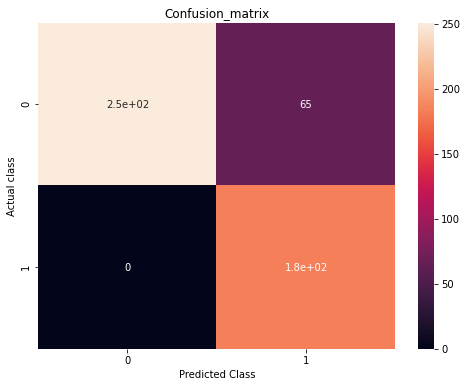

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [264]:
xgb = XGBClassifier(learning_rate=0.3, n_estimators=10, max_depth=2, min_child_weight=1, gamma=0, objective= 'binary:logistic', 
                    nthread=4, seed=1)

xgb.fit(X_train ,Y_train)

featimp = pd.Series(xgb.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = xgb.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Random Forests

Recency Score                              0.491892
Frequency Score                            0.074391
Monetary Score                             0.055287
Number_of_Campaigns                        0.041951
_Campaign18                                0.031174
_Campaign13                                0.018243
_Campaign8                                 0.014696
Number_of_Coupons_Redeemed_By_Household    0.014091
Store_446                                  0.011908
Store_380                                  0.010468
Campaign_Type_Most_Received_TypeB          0.009460
Store_424                                  0.008962
Store_381                                  0.008896
Store_367                                  0.008874
Store_375                                  0.008840
Store_335                                  0.008759
Store_296                                  0.008538
Store_343                                  0.008405
Store_321                                  0.008208
Campaign_Typ

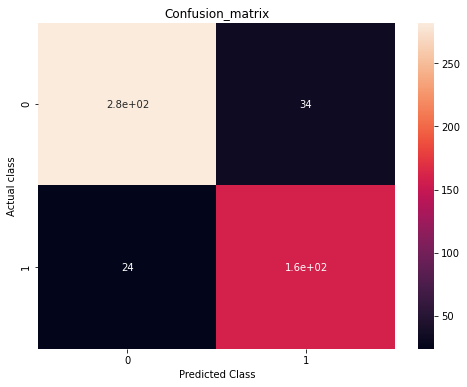

Confusion matrix: 
 [[282  34]
 [ 24 160]]
TP:  160
TN:  282
FP:  34
FN:  24


In [265]:
rfc = RandomForestClassifier(n_estimators=400, criterion='gini', max_features='auto', random_state=1)

rfc.fit(X_train,Y_train)

featimp = pd.Series(rfc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = rfc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# AdaBoost

Recency Score                              0.2
Store_446                                  0.1
_Campaign25                                0.1
_Campaign23                                0.1
Number_of_Coupons_Redeemed_By_Household    0.1
Store_372                                  0.1
Store_31782                                0.1
Store_412                                  0.1
_Campaign29                                0.1
_Campaign1                                 0.0
_Campaign28                                0.0
_Campaign27                                0.0
_Campaign26                                0.0
Frequency Score                            0.0
_Campaign24                                0.0
Monetary Score                             0.0
_Campaign22                                0.0
_Campaign21                                0.0
_Campaign20                                0.0
_Campaign11                                0.0
_Campaign12                                0.0
_Campaign19  

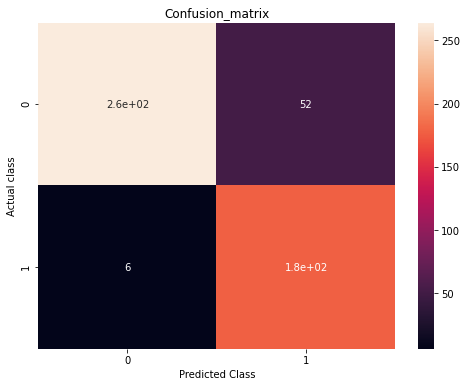

Confusion matrix: 
 [[264  52]
 [  6 178]]
TP:  178
TN:  264
FP:  52
FN:  6


In [266]:
abc = AdaBoostClassifier(n_estimators=10, random_state=1)

abc.fit(X_train,Y_train)

featimp = pd.Series(abc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = abc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Gradient Boosting

Recency Score                              0.923262
Number_of_Coupons_Redeemed_By_Household    0.009461
Store_412                                  0.006612
Store_446                                  0.005049
_Campaign25                                0.004841
Store_321                                  0.004839
Store_380                                  0.004718
Frequency Score                            0.003845
_Campaign18                                0.003557
Store_296                                  0.003281
Number_of_Campaigns                        0.002626
_Campaign14                                0.002540
Store_318                                  0.002502
Store_367                                  0.002404
Store_372                                  0.002329
Store_298                                  0.002329
Monetary Score                             0.002272
Store_335                                  0.002209
Store_31782                                0.002095
_Campaign23 

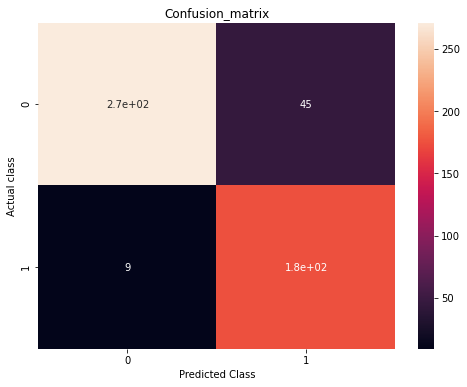

Confusion matrix: 
 [[271  45]
 [  9 175]]
TP:  175
TN:  271
FP:  45
FN:  9


In [267]:
gbc = GradientBoostingClassifier(n_estimators= 10, max_depth=5, max_leaf_nodes=8, learning_rate=0.5, random_state=1)

gbc.fit(X_train,Y_train)

featimp = pd.Series(gbc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = gbc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Support Vector Classifiers

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.01      0.01       316
           1       0.37      1.00      0.54       184

    accuracy                           0.37       500
   macro avg       0.68      0.50      0.28       500
weighted avg       0.77      0.37      0.21       500



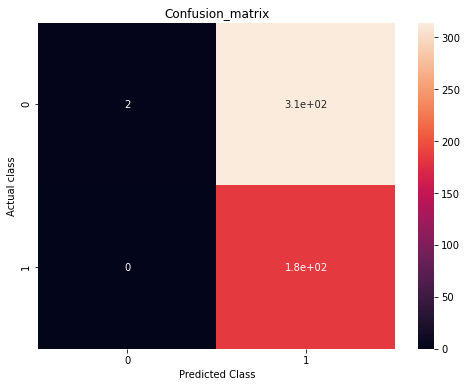

Confusion matrix: 
 [[  2 314]
 [  0 184]]
TP:  184
TN:  2
FP:  314
FN:  0


In [268]:
svc = SVC(C= 10, kernel='poly', gamma=0.001, random_state=1)

svc.fit(X_train,Y_train)

Y_pred = svc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Logistic Regression

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.85      0.91       316
           1       0.79      0.97      0.87       184

    accuracy                           0.89       500
   macro avg       0.89      0.91      0.89       500
weighted avg       0.91      0.89      0.90       500



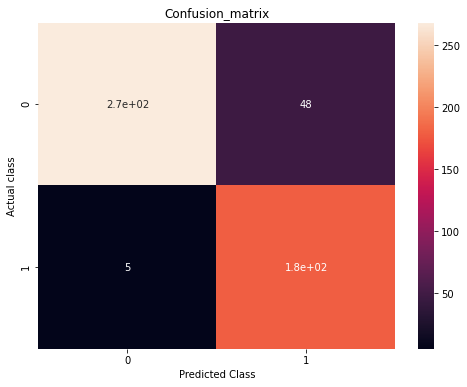

Confusion matrix: 
 [[268  48]
 [  5 179]]
TP:  179
TN:  268
FP:  48
FN:  5


In [269]:
lr = LogisticRegression(penalty='l2', C=0.1, random_state=1, solver='lbfgs', max_iter=10000)
lr.fit(X_train,Y_train)

Y_pred = lr.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# k-Nearest Neighbours

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.84      0.87       316
           1       0.76      0.85      0.80       184

    accuracy                           0.84       500
   macro avg       0.83      0.84      0.84       500
weighted avg       0.85      0.84      0.85       500



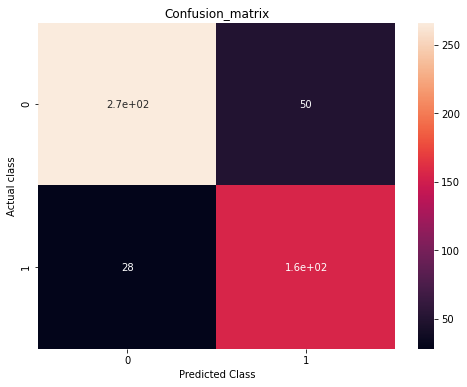

Confusion matrix: 
 [[266  50]
 [ 28 156]]
TP:  156
TN:  266
FP:  50
FN:  28


In [270]:
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='brute', leaf_size=1,p=2)
knn.fit(X_train,Y_train)

Y_pred = knn.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Naive Bayes

Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.22      0.36       316
           1       0.42      0.97      0.59       184

    accuracy                           0.50       500
   macro avg       0.68      0.60      0.47       500
weighted avg       0.74      0.50      0.44       500



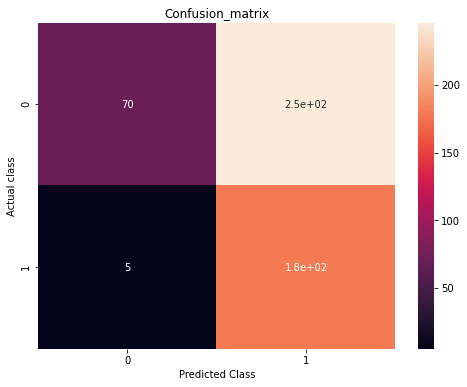

Confusion matrix: 
 [[ 70 246]
 [  5 179]]
TP:  179
TN:  70
FP:  246
FN:  5


In [271]:
naive_bayes_classifier = GaussianNB(var_smoothing=1)

naive_bayes_classifier.fit(X_train, Y_train)

Y_pred = naive_bayes_classifier.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# MAKING PREDICTIONS ON THE TEST SET WITH THE BEST PERFORMING BASELINE CLASSIFIER THAT WAS IDENTIFIED AS THE FIRST STAGE CLASSIFIER

In [269]:
X_test

,Recency Score,Frequency Score,Monetary Score,_Campaign1,_Campaign10,_Campaign11,_Campaign12,_Campaign13,_Campaign14,_Campaign15,...,Store_450,Store_31782,Store_446,Store_445,Store_292,Store_335,Store_421,Store_296,Store_380,Store_313
1247,-0.488003,1.343791,1.341641,-0.072299,4.396044,3.268370,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
489,-0.488003,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
1161,-1.389708,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
2121,1.315408,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
1780,-0.488003,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,1.315408,-0.445068,-0.447214,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
1462,0.413702,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,3.644957,3.447695,-0.241713,3.419116,-0.268405,3.428571,-0.22356
2315,-1.389708,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,4.137142,-0.292473,-0.268405,-0.291667,-0.22356
582,-1.389708,1.343791,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356


# XGBoost is the best performing baseline classifier and is hence, the first stage classifier that will be used to train second stage classifiers

Recency Score                              1.0
_Campaign2                                 0.0
_Campaign30                                0.0
_Campaign3                                 0.0
_Campaign29                                0.0
_Campaign28                                0.0
_Campaign27                                0.0
_Campaign26                                0.0
_Campaign25                                0.0
_Campaign24                                0.0
_Campaign23                                0.0
_Campaign22                                0.0
_Campaign21                                0.0
_Campaign20                                0.0
_Campaign19                                0.0
Store_380                                  0.0
_Campaign18                                0.0
_Campaign17                                0.0
_Campaign16                                0.0
_Campaign15                                0.0
_Campaign14                                0.0
_Campaign13  

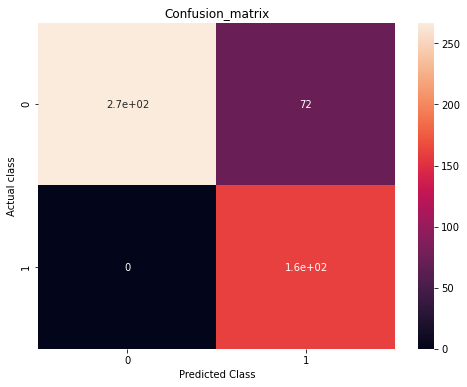

Confusion matrix: 
 [[267  72]
 [  0 161]]
TP:  161
TN:  267
FP:  72
FN:  0


In [270]:
#XGBoost seems to be the best baseline classifier - have a look at the confusion matrix - keep an eye on the recall score and accuracy
xgb = XGBClassifier(learning_rate=0.3, n_estimators=10, max_depth=2, min_child_weight=1, gamma=0, objective='binary:logistic', 
                    nthread=4, seed=1)

Predictions_DF = X_test.copy()
Predictions_DF['Churned Variable']= Y_test

xgb.fit(X_train,Y_train)
featimp = pd.Series(xgb.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Predictions_DF['Y_pred'] = xgb.predict(X_test)

print('Classification report: \n', metrics.classification_report(Y_test, Predictions_DF['Y_pred']))

conf_mat = metrics.confusion_matrix(Y_test, Predictions_DF['Y_pred'])
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

In [271]:
#Get the Predictions and the original test set into a separate data frame
Predictions_DF

,Recency Score,Frequency Score,Monetary Score,_Campaign1,_Campaign10,_Campaign11,_Campaign12,_Campaign13,_Campaign14,_Campaign15,...,Store_446,Store_445,Store_292,Store_335,Store_421,Store_296,Store_380,Store_313,Churned Variable,Y_pred
1247,-0.488003,1.343791,1.341641,-0.072299,4.396044,3.268370,-0.270114,1.149462,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,0,1
489,-0.488003,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,1,1
1161,-1.389708,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,1,1
2121,1.315408,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,0,0
1780,-0.488003,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,1.315408,-0.445068,-0.447214,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,0,0
1462,0.413702,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.30908,3.644957,3.447695,-0.241713,3.419116,-0.268405,3.428571,-0.22356,0,0
2315,-1.389708,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,4.137142,-0.292473,-0.268405,-0.291667,-0.22356,1,1
582,-1.389708,1.343791,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,1,1


# Filtering the data frame so as to retain only the correctly predicted values

In [272]:
#Filtering the data frame so as to retain only the correctly predicted values where Churned Variable = Y_pred
Training_Set_For_Second_Stage_Classifier = Predictions_DF[Predictions_DF['Churned Variable']==Predictions_DF['Y_pred']]

In [280]:
Training_Set_For_Second_Stage_Classifier

,Recency Score,Frequency Score,Monetary Score,_Campaign1,_Campaign10,_Campaign11,_Campaign12,_Campaign13,_Campaign14,_Campaign15,...,Store_446,Store_445,Store_292,Store_335,Store_421,Store_296,Store_380,Store_313,Churned Variable,Y_pred
489,-0.488003,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,1,1
1161,-1.389708,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,1,1
2121,1.315408,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,0,0
1780,-0.488003,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,1,1
1344,-1.389708,-0.445068,-0.447214,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.30908,3.644957,-0.290049,-0.241713,3.419116,-0.268405,3.428571,-0.22356,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,1.315408,-0.445068,-0.447214,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,0,0
1462,0.413702,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.30908,3.644957,3.447695,-0.241713,3.419116,-0.268405,3.428571,-0.22356,0,0
2315,-1.389708,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,4.137142,-0.292473,-0.268405,-0.291667,-0.22356,1,1
582,-1.389708,1.343791,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356,1,1


In [273]:
#Get the X and Y values
#Y will be the original target variable
#X will be all the other columns
Y_train_Second_Stage = Training_Set_For_Second_Stage_Classifier['Churned Variable']
Y_train_Second_Stage

489     1
1161    1
2121    0
1780    1
1344    1
       ..
1561    0
1462    0
2315    1
582     1
2274    0
Name: Churned Variable, Length: 428, dtype: int64

In [274]:
X_train_Second_Stage = Training_Set_For_Second_Stage_Classifier.drop(['Churned Variable', 'Y_pred'], axis=1)
X_train_Second_Stage

,Recency Score,Frequency Score,Monetary Score,_Campaign1,_Campaign10,_Campaign11,_Campaign12,_Campaign13,_Campaign14,_Campaign15,...,Store_450,Store_31782,Store_446,Store_445,Store_292,Store_335,Store_421,Store_296,Store_380,Store_313
489,-0.488003,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
1161,-1.389708,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
2121,1.315408,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
1780,-0.488003,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
1344,-1.389708,-0.445068,-0.447214,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,3.644957,-0.290049,-0.241713,3.419116,-0.268405,3.428571,-0.22356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,1.315408,-0.445068,-0.447214,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356
1462,0.413702,0.449361,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,3.644957,3.447695,-0.241713,3.419116,-0.268405,3.428571,-0.22356
2315,-1.389708,-1.339497,-1.341641,-0.072299,-0.227477,-0.305963,-0.270114,-0.869972,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,4.137142,-0.292473,-0.268405,-0.291667,-0.22356
582,-1.389708,1.343791,0.447214,-0.072299,-0.227477,-0.305963,-0.270114,1.149462,-0.313717,-0.082744,...,-0.264963,-0.240784,-0.30908,-0.274352,-0.290049,-0.241713,-0.292473,-0.268405,-0.291667,-0.22356


In [275]:
# Implementing Oversampling to balance the dataset; SMOTE stands for Synthetic Minority Oversampling Technique
print("Number of observations in each class before oversampling (training data): \n", pd.Series(Y_train_Second_Stage).value_counts())

smote = SMOTE(random_state = 101)
X_train_Second_Stage,Y_train_Second_Stage = smote.fit_sample(X_train_Second_Stage,Y_train_Second_Stage)

print("Number of observations in each class after oversampling (training data): \n", pd.Series(Y_train_Second_Stage).value_counts())

Number of observations in each class before oversampling (training data): 
 0    267
1    161
Name: Churned Variable, dtype: int64
Number of observations in each class after oversampling (training data): 
 1    267
0    267
Name: Churned Variable, dtype: int64


# Training second stage classifiers - full feature scenario

# Random Forest

In [276]:
#Training second stage classifiers
# Tuning the random forest parameter 'n_estimators' and implementing cross-validation using Grid Search
#Model must correctly predict customer churn
#TP – correctly predicting customer churn
#TN - correctly predicting customer non-churn
#FP – predicting that a customer churned when the customer is actually did not churn
#FN - predicting that a customer did not churn when the customer is actually churned
#FN is dangerous 

rfc = RandomForestClassifier(max_features='auto', random_state=1)
grid_param = {'n_estimators': [50,100,150,200,250,300,350,400,450,500], 'criterion':['gini', 'entropy']}

gd_sr = GridSearchCV(estimator=rfc, param_grid=grid_param, scoring='recall', n_jobs=10, cv=10, verbose=True)

# """
# In the above GridSearchCV(), scoring parameter should be set as follows:
# scoring = 'accuracy' when you want to maximize prediction accuracy
# scoring = 'recall' when you want to minimize false negatives
# scoring = 'precision' when you want to minimize false positives
# scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
# """
#
gd_sr.fit(X_train_Second_Stage, Y_train_Second_Stage)
best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   27.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:  2.0min finished


{'criterion': 'gini', 'n_estimators': 100}
1.0


# AdaBoost

In [303]:
# Tuning the AdaBoost parameter 'n_estimators' and implementing cross-validation using Grid Search
abc = AdaBoostClassifier(random_state=1)
grid_param = {'n_estimators': [5,10,20,30,40,50,60,70,80,90,100]}

gd_sr = GridSearchCV(estimator=abc, param_grid=grid_param, scoring='recall', n_jobs=10, cv=10, verbose=True)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train_Second_Stage, Y_train_Second_Stage)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  91 out of 110 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=10)]: Done 110 out of 110 | elapsed:    1.4s finished


{'n_estimators': 5}
1.0


# Gradient Boosting

In [277]:
#Tuning the Gradient Boost parameter 'n_estimators' and implementing cross-validation using Grid Search
gbc = GradientBoostingClassifier(random_state=1)
grid_param = {'n_estimators': [10,20,30,40,50], 'max_depth' : [5,6,7,8,9,10,11,12,13,14,15,16], 
              'max_leaf_nodes': [8,12,16,20,24,28,32], 'learning_rate':[0.5, 0.4, 0.3, 0.2, 0.1, 0.001, 0.005]}

gd_sr = GridSearchCV(estimator=gbc, param_grid=grid_param, scoring='recall', n_jobs = 10, cv=10, verbose=True)
#
# """
# In the above GridSearchCV(), scoring parameter should be set as follows:
# scoring = 'accuracy' when you want to maximize prediction accuracy
# scoring = 'recall' when you want to minimize false negatives
# scoring = 'precision' when you want to minimize false positives
# scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
# """
#
gd_sr.fit(X_train_Second_Stage, Y_train_Second_Stage)

best_parameters = gd_sr.best_params_
print(best_parameters)
#
best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 2940 candidates, totalling 29400 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:   15.2s
[Parallel(n_jobs=10)]: Done 670 tasks      | elapsed:   30.8s
[Parallel(n_jobs=10)]: Done 1020 tasks      | elapsed:   49.7s
[Parallel(n_jobs=10)]: Done 1470 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2020 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 2670 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 3420 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 4270 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 5220 tasks      | elapsed:  4.2min
[Parallel(n_jobs=10)]: Done 6270 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 7420 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 8670 tasks      | elapsed:  7.1min
[Parallel(n_jobs=10)]: Done 10020 tasks      | elapsed:  8.4min
[Parallel(n_jobs=10)]: Done 11470 tasks    

{'learning_rate': 0.5, 'max_depth': 5, 'max_leaf_nodes': 8, 'n_estimators': 10}
1.0


# XGBoost

In [305]:
estimator = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=1)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(10, 60, 10),
    'learning_rate': [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.05],
    'gamma': [0,0.1,0.2,0.3,0.4,0.5],
    'min_child_weight':range(1,10,1)
}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs = 10, cv = 10, verbose=True)

grid_search.fit(X_train_Second_Stage, Y_train_Second_Stage)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 15120 candidates, totalling 151200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   21.0s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   36.4s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   51.7s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed:  3.6min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed:  4.3min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed:  5.9min
[Parallel(n_jobs=10)]: Done 11230 tasks      

{'gamma': 0, 'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 10}
1.0


# Support Vector Classifiers

In [306]:
#Training SVMs
estimator = SVC(random_state=1)
parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs=10, cv=10, verbose=True)
grid_search.fit(X_train_Second_Stage, Y_train_Second_Stage)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 326 tasks      | elapsed:    7.5s


{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
1.0


[Parallel(n_jobs=10)]: Done 640 out of 640 | elapsed:   13.9s finished


# Logistic Regression

In [283]:
#Logistic Regression
estimator = LogisticRegression(max_iter=10000)
parameters = {'solver':['sag', 'lbfgs', 'saga'], 'penalty':['l2'], 'C':[100, 10, 1.0, 0.1, 0.01]}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs=10, cv=10, verbose=True)
grid_search.fit(X_train_Second_Stage, Y_train_Second_Stage)

best_parameters = grid_search.best_params_
print(best_parameters)

best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.1s finished


{'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.9962962962962962


# k-Nearest Neighbours

In [308]:
#k-nearest neighbours

estimator = KNeighborsClassifier()

parameters = {'leaf_size':range (1,61),'n_neighbors':range(1,31),'p':[1,2],'weights':['uniform', 'distance'], 
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs = 10, cv = 10, verbose=True)

grid_search.fit(X_train_Second_Stage, Y_train_Second_Stage)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 28800 candidates, totalling 288000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   13.9s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   25.9s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   41.6s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   56.3s
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed:  3.7min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done 11230 tasks      

{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
0.9814814814814815


# Naive Bayes

In [279]:
#Naive Bayes

naive_bayes_classifier = GaussianNB()

parameters_naive_bayes = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_search = GridSearchCV(estimator=naive_bayes_classifier, param_grid=parameters_naive_bayes, scoring = 'recall', n_jobs = 10, 
                           cv = 10, verbose=True) 

grid_search.fit(X_train_Second_Stage, Y_train_Second_Stage)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 620 tasks      | elapsed:    5.9s


{'var_smoothing': 1.0}
0.9555555555555555


[Parallel(n_jobs=10)]: Done 981 out of 1000 | elapsed:    9.6s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    9.7s finished


# Predictions by Second Stage Classifiers Utilizing All Features

# XGBoost

Recency Score                              1.0
_Campaign2                                 0.0
_Campaign30                                0.0
_Campaign3                                 0.0
_Campaign29                                0.0
_Campaign28                                0.0
_Campaign27                                0.0
_Campaign26                                0.0
_Campaign25                                0.0
_Campaign24                                0.0
_Campaign23                                0.0
_Campaign22                                0.0
_Campaign21                                0.0
_Campaign20                                0.0
_Campaign19                                0.0
Store_380                                  0.0
_Campaign18                                0.0
_Campaign17                                0.0
_Campaign16                                0.0
_Campaign15                                0.0
_Campaign14                                0.0
_Campaign13  

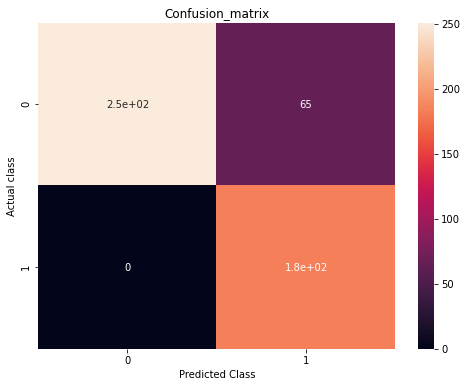

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [310]:
#Make Predictions and see the results
xgb = XGBClassifier(learning_rate=0.5, n_estimators=10, max_depth=2, min_child_weight=1, gamma=0, objective= 'binary:logistic', 
                    nthread=4, seed=1)

xgb.fit(X_train_Second_Stage,Y_train_Second_Stage)

featimp = pd.Series(xgb.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = xgb.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Random Forest

Recency Score                              0.575655
Frequency Score                            0.075208
Monetary Score                             0.069097
Number_of_Campaigns                        0.029771
_Campaign13                                0.028309
_Campaign8                                 0.024043
_Campaign18                                0.019054
Number_of_Coupons_Redeemed_By_Household    0.012122
_Campaign30                                0.011705
Campaign_Type_Most_Received_TypeA          0.008094
_Campaign22                                0.006533
Store_318                                  0.006429
Store_375                                  0.006346
Store_367                                  0.006322
_Campaign26                                0.005951
_Campaign14                                0.005682
Store_446                                  0.005160
Campaign_Type_Most_Received_TypeB          0.004992
Store_424                                  0.004965
Store_372   

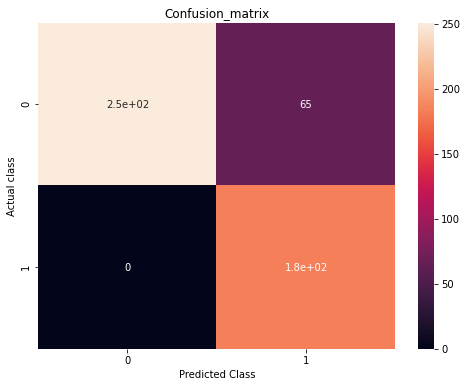

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [284]:
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', max_features='auto', random_state=1)

rfc.fit(X_train_Second_Stage,Y_train_Second_Stage)

featimp = pd.Series(rfc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = rfc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# AdaBoost

Recency Score                              1.0
_Campaign2                                 0.0
_Campaign30                                0.0
_Campaign3                                 0.0
_Campaign29                                0.0
_Campaign28                                0.0
_Campaign27                                0.0
_Campaign26                                0.0
_Campaign25                                0.0
_Campaign24                                0.0
_Campaign23                                0.0
_Campaign22                                0.0
_Campaign21                                0.0
_Campaign20                                0.0
_Campaign19                                0.0
Store_380                                  0.0
_Campaign18                                0.0
_Campaign17                                0.0
_Campaign16                                0.0
_Campaign15                                0.0
_Campaign14                                0.0
_Campaign13  

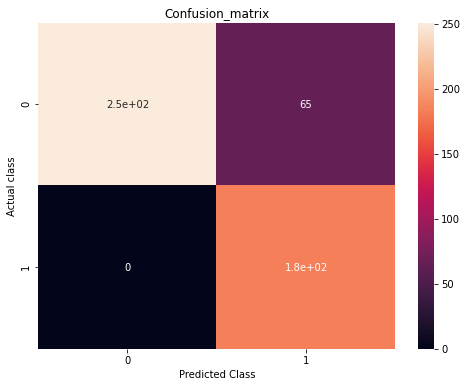

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [312]:
abc = AdaBoostClassifier(n_estimators=5, random_state=1)

abc.fit(X_train_Second_Stage,Y_train_Second_Stage)

featimp = pd.Series(abc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = abc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Gradient Boosting

Recency Score                              1.000000e+00
Number_of_Coupons_Redeemed_By_Household    6.464778e-16
Number_of_Campaigns                        1.829388e-16
Frequency Score                            7.762120e-17
Monetary Score                             6.838815e-17
_Campaign18                                2.997296e-17
Store_343                                  6.818963e-18
Store_372                                  1.213205e-18
Store_292                                  1.785865e-19
_Campaign16                                6.535028e-20
Campaign_Type_Most_Received_TypeC          2.295710e-20
Store_318                                  1.633757e-20
_Campaign11                                0.000000e+00
_Campaign20                                0.000000e+00
_Campaign28                                0.000000e+00
_Campaign27                                0.000000e+00
_Campaign26                                0.000000e+00
_Campaign24                                0.000

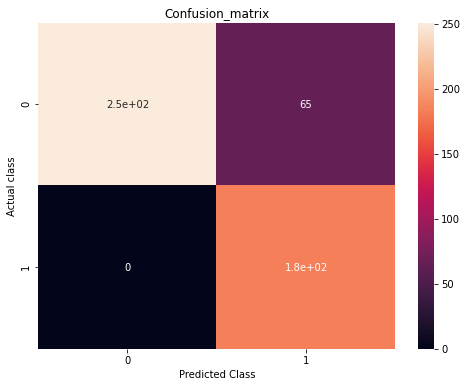

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [285]:
gbc = GradientBoostingClassifier(n_estimators= 10, max_depth=5, max_leaf_nodes=8, learning_rate=0.5, random_state=1)

gbc.fit(X_train_Second_Stage,Y_train_Second_Stage)

featimp = pd.Series(gbc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = gbc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Support Vector Classifier

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.89       316
           1       0.74      1.00      0.85       184

    accuracy                           0.87       500
   macro avg       0.87      0.90      0.87       500
weighted avg       0.90      0.87      0.87       500



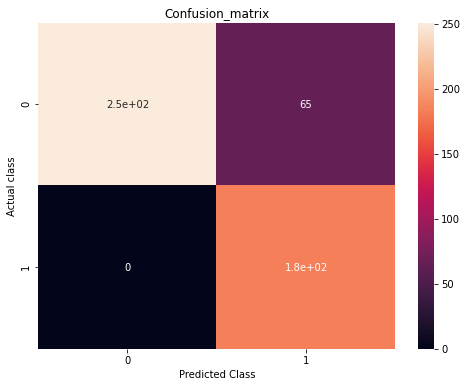

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [314]:
svc = SVC(C= 0.1, kernel='linear', gamma=1, random_state=1)

svc.fit(X_train_Second_Stage,Y_train_Second_Stage)

Y_pred = svc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Running Models for the Balanced Data Set with Reduced Features - The Top 5 Features are considered

In [286]:
#Get the predictions for the best performing first stage classifier XGBoost with only the top 5 features
X = final_model_data_set.drop(['household_key', 'Churn Variable'], axis = 1) # Features
Y = final_model_data_set['Churn Variable'] # Labels

In [287]:
X = X[['Recency Score', '_Campaign2', '_Campaign30', '_Campaign3', '_Campaign29']]
X

,Recency Score,_Campaign2,_Campaign30,_Campaign3,_Campaign29
0,3,0.0,0.0,0.0,1.0
1,1,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0
4,2,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2495,1,0.0,0.0,0.0,0.0
2496,2,0.0,0.0,0.0,0.0
2497,4,0.0,0.0,0.0,0.0
2498,3,0.0,0.0,0.0,0.0


In [288]:
Y

0       0
1       1
2       0
3       1
4       0
       ..
2495    1
2496    0
2497    0
2498    0
2499    0
Name: Churn Variable, Length: 2500, dtype: int64

In [289]:
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(2500, 5)
(2500,)


In [290]:
list_X = list(X.columns)
list_X

['Recency Score', '_Campaign2', '_Campaign30', '_Campaign3', '_Campaign29']

In [291]:
feature_scaler = StandardScaler()
X[['Recency Score','_Campaign2','_Campaign30', '_Campaign3','_Campaign29']] = feature_scaler.fit_transform(X[['Recency Score','_Campaign2','_Campaign30', '_Campaign3','_Campaign29']])

In [292]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=100)

In [293]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1500, 5)
(500, 5)
(500, 5)


In [294]:
smote = SMOTE(random_state = 101)
X_train,Y_train = smote.fit_sample(X_train,Y_train)

# Running the XGBoost algorithm with only the top 5 features

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.88       339
           1       0.69      1.00      0.82       161

    accuracy                           0.86       500
   macro avg       0.85      0.89      0.85       500
weighted avg       0.90      0.86      0.86       500



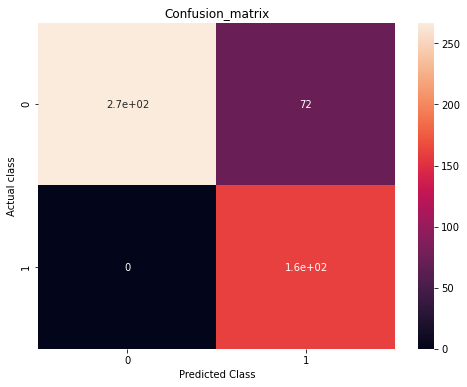

Confusion matrix: 
 [[267  72]
 [  0 161]]
TP:  161
TN:  267
FP:  72
FN:  0


In [258]:
X_train,Y_train = smote.fit_sample(X_train,Y_train)
xgb = XGBClassifier(learning_rate=0.3, n_estimators=10, max_depth=2, min_child_weight=1, gamma=0, objective= 'binary:logistic', 
                    nthread=4, seed=1)

Predictions_DF = X_test.copy()
Predictions_DF['Churned Variable']= Y_test

xgb.fit(X_train,Y_train)
Predictions_DF['Y_pred'] = xgb.predict(X_test)

print('Classification report: \n', metrics.classification_report(Y_test, Predictions_DF['Y_pred']))

conf_mat = metrics.confusion_matrix(Y_test, Predictions_DF['Y_pred'])
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

In [259]:
Predictions_DF

,Recency Score,_Campaign2,_Campaign30,_Campaign3,_Campaign29,Churned Variable,Y_pred
1247,-0.488003,-0.139914,-0.410817,-0.069449,-0.222572,0,1
489,-0.488003,-0.139914,2.434175,-0.069449,-0.222572,1,1
1161,-1.389708,-0.139914,-0.410817,-0.069449,-0.222572,1,1
2121,1.315408,-0.139914,-0.410817,-0.069449,-0.222572,0,0
1780,-0.488003,-0.139914,-0.410817,-0.069449,-0.222572,1,1
...,...,...,...,...,...,...,...
1561,1.315408,-0.139914,-0.410817,-0.069449,-0.222572,0,0
1462,0.413702,-0.139914,2.434175,-0.069449,-0.222572,0,0
2315,-1.389708,-0.139914,2.434175,-0.069449,-0.222572,1,1
582,-1.389708,7.147261,-0.410817,-0.069449,-0.222572,1,1


# Filter the data frame so as to retain only the correctly predicted values where Churned Variable = Y_pred in the reduced features scenario

In [261]:
#Filter the data frame so as to retain only the correctly predicted values where Churned Variable = Y_pred
Training_Set_For_Second_Stage_Classifier_Reduced_Features = Predictions_DF[Predictions_DF['Churned Variable']==Predictions_DF['Y_pred']]

In [262]:
Training_Set_For_Second_Stage_Classifier_Reduced_Features

,Recency Score,_Campaign2,_Campaign30,_Campaign3,_Campaign29,Churned Variable,Y_pred
489,-0.488003,-0.139914,2.434175,-0.069449,-0.222572,1,1
1161,-1.389708,-0.139914,-0.410817,-0.069449,-0.222572,1,1
2121,1.315408,-0.139914,-0.410817,-0.069449,-0.222572,0,0
1780,-0.488003,-0.139914,-0.410817,-0.069449,-0.222572,1,1
1344,-1.389708,-0.139914,2.434175,-0.069449,-0.222572,1,1
...,...,...,...,...,...,...,...
1561,1.315408,-0.139914,-0.410817,-0.069449,-0.222572,0,0
1462,0.413702,-0.139914,2.434175,-0.069449,-0.222572,0,0
2315,-1.389708,-0.139914,2.434175,-0.069449,-0.222572,1,1
582,-1.389708,7.147261,-0.410817,-0.069449,-0.222572,1,1


In [263]:
#Get the X and Y values
#Y will be the original target variable
#X will be all the other columns
Y_train_Second_Stage_Reduced_Features = Training_Set_For_Second_Stage_Classifier_Reduced_Features['Churned Variable']
Y_train_Second_Stage_Reduced_Features

489     1
1161    1
2121    0
1780    1
1344    1
       ..
1561    0
1462    0
2315    1
582     1
2274    0
Name: Churned Variable, Length: 428, dtype: int64

In [264]:
X_train_Second_Stage_Reduced_Features = Training_Set_For_Second_Stage_Classifier_Reduced_Features.drop(['Churned Variable', 'Y_pred'], axis=1)
X_train_Second_Stage_Reduced_Features

,Recency Score,_Campaign2,_Campaign30,_Campaign3,_Campaign29
489,-0.488003,-0.139914,2.434175,-0.069449,-0.222572
1161,-1.389708,-0.139914,-0.410817,-0.069449,-0.222572
2121,1.315408,-0.139914,-0.410817,-0.069449,-0.222572
1780,-0.488003,-0.139914,-0.410817,-0.069449,-0.222572
1344,-1.389708,-0.139914,2.434175,-0.069449,-0.222572
...,...,...,...,...,...
1561,1.315408,-0.139914,-0.410817,-0.069449,-0.222572
1462,0.413702,-0.139914,2.434175,-0.069449,-0.222572
2315,-1.389708,-0.139914,2.434175,-0.069449,-0.222572
582,-1.389708,7.147261,-0.410817,-0.069449,-0.222572


In [266]:
# Implementing Oversampling to balance the dataset; SMOTE stands for Synthetic Minority Oversampling Technique
print("Number of observations in each class before oversampling (training data): \n", pd.Series(Y_train_Second_Stage_Reduced_Features).value_counts())

smote = SMOTE(random_state = 101)
X_train_Second_Stage_Reduced_Features,Y_train_Second_Stage_Reduced_Features = smote.fit_sample(X_train_Second_Stage_Reduced_Features,Y_train_Second_Stage_Reduced_Features)

print("Number of observations in each class after oversampling (training data): \n", pd.Series(Y_train_Second_Stage_Reduced_Features).value_counts())

Number of observations in each class before oversampling (training data): 
 0    267
1    161
Name: Churned Variable, dtype: int64
Number of observations in each class after oversampling (training data): 
 1    267
0    267
Name: Churned Variable, dtype: int64


# Training Second Stage Classifiers in the Reduced Features Scenario

# Random Forest

In [268]:
#Training second stage classifiers
# Tuning the random forest parameter 'n_estimators' and implementing cross-validation using Grid Search
#Model must correctly predict customer churn
#TP – correctly predicting customer churn
#TN - correctly predicting customer non-churn
#FP – predicting that a customer churned when the customer is actually did not churn
#FN - predicting that a customer did not churn when the customer is actually churned
#FN is dangerous 

rfc = RandomForestClassifier(max_features='auto', random_state=1)
grid_param = {'n_estimators': [50,100,150,200,250,300,350,400,450,500], 'criterion':['gini', 'entropy']}

gd_sr = GridSearchCV(estimator=rfc, param_grid=grid_param, scoring='recall', n_jobs=10, cv=10, verbose=True)

# """
# In the above GridSearchCV(), scoring parameter should be set as follows:
# scoring = 'accuracy' when you want to maximize prediction accuracy
# scoring = 'recall' when you want to minimize false negatives
# scoring = 'precision' when you want to minimize false positives
# scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
# """
#
gd_sr.fit(X_train_Second_Stage_Reduced_Features, Y_train_Second_Stage_Reduced_Features)
best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   22.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:  1.8min finished


{'criterion': 'gini', 'n_estimators': 50}
1.0


# AdaBoost

In [356]:
# Tuning the AdaBoost parameter 'n_estimators' and implementing cross-validation using Grid Search
abc = AdaBoostClassifier(random_state=1)
grid_param = {'n_estimators': [5,10,20,30,40,50,60,70,80,90,100]}

gd_sr = GridSearchCV(estimator=abc, param_grid=grid_param, scoring='recall', n_jobs=10, cv=10, verbose=True)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train_Second_Stage_Reduced_Features, Y_train_Second_Stage_Reduced_Features)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.6s


{'n_estimators': 5}
1.0


[Parallel(n_jobs=10)]: Done 110 out of 110 | elapsed:    1.5s finished


# Gradient Boosting

In [269]:
#Tuning the Gradient Boost parameter 'n_estimators' and implementing cross-validation using Grid Search
gbc = GradientBoostingClassifier(random_state=1)
grid_param = {'n_estimators': [10,20,30,40,50], 'max_depth' : [5,6,7,8,9,10,11,12,13,14,15,16], 
              'max_leaf_nodes': [8,12,16,20,24,28,32],
             'learning_rate':[0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.05]}

gd_sr = GridSearchCV(estimator=gbc, param_grid=grid_param, scoring='recall', n_jobs = 10, cv=10, verbose=True)
#
# """
# In the above GridSearchCV(), scoring parameter should be set as follows:
# scoring = 'accuracy' when you want to maximize prediction accuracy
# scoring = 'recall' when you want to minimize false negatives
# scoring = 'precision' when you want to minimize false positives
# scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
# """
#
gd_sr.fit(X_train_Second_Stage_Reduced_Features, Y_train_Second_Stage_Reduced_Features)

best_parameters = gd_sr.best_params_
print(best_parameters)
#
best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 2940 candidates, totalling 29400 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   23.1s
[Parallel(n_jobs=10)]: Done 1540 tasks      | elapsed:   42.0s
[Parallel(n_jobs=10)]: Done 2440 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 3540 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 4840 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 6340 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 8040 tasks      | elapsed:  3.6min
[Parallel(n_jobs=10)]: Done 9940 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done 12040 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 14340 tasks      | elapsed:  6.3min
[Parallel(n_jobs=10)]: Done 16840 tasks      | elapsed:  7.4min
[Parallel(n_jobs=10)]: Done 19070 tasks      | elapsed:  8.6min
[Parallel(n_jobs=10)]: Done 20520 tasks 

{'learning_rate': 0.5, 'max_depth': 5, 'max_leaf_nodes': 8, 'n_estimators': 10}
1.0


# XGBoost

In [358]:
estimator = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=1)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(10, 60, 10),
    'learning_rate': [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.05],
    'gamma': [0,0.1,0.2,0.3,0.4,0.5],
    'min_child_weight':range(1,10,1)
}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs = 10, cv = 10, verbose=True)

grid_search.fit(X_train_Second_Stage_Reduced_Features, Y_train_Second_Stage_Reduced_Features)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 15120 candidates, totalling 151200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   15.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   25.3s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   34.9s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   45.4s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   57.2s
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed:  4.0min
[Parallel(n_jobs=10)]: Done 11230 tasks      

{'gamma': 0, 'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 10}
1.0


# Support Vector Classifiers

In [359]:
#Training SVMs
estimator = SVC(random_state=1)
parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs=10, cv=10, verbose=True)
grid_search.fit(X_train_Second_Stage_Reduced_Features, Y_train_Second_Stage_Reduced_Features)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    3.7s


{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
1.0


[Parallel(n_jobs=10)]: Done 640 out of 640 | elapsed:    6.5s finished


# Logistic Regression

In [272]:
#Logistic Regression
estimator = LogisticRegression(max_iter=10000)
parameters = {'solver':['saga', 'lbfgs', 'sag'], 'penalty':['l2'], 'C':[100, 10, 1.0, 0.1, 0.01]}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs=10, cv=10, verbose=True)
grid_search.fit(X_train_Second_Stage_Reduced_Features, Y_train_Second_Stage_Reduced_Features)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.1s


{'C': 100, 'penalty': 'l2', 'solver': 'saga'}
1.0


[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    2.7s finished


# K-Nearest Neighbours

In [361]:
estimator = KNeighborsClassifier()

parameters = {'leaf_size':range (1,61),'n_neighbors':range(1,31),'p':[1,2],'weights':['uniform', 'distance'], 
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'recall', n_jobs = 10, cv = 10, verbose=True)

grid_search.fit(X_train_Second_Stage_Reduced_Features, Y_train_Second_Stage_Reduced_Features)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 28800 candidates, totalling 288000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:    9.3s
[Parallel(n_jobs=10)]: Done 1540 tasks      | elapsed:   16.9s
[Parallel(n_jobs=10)]: Done 2440 tasks      | elapsed:   26.4s
[Parallel(n_jobs=10)]: Done 3540 tasks      | elapsed:   37.9s
[Parallel(n_jobs=10)]: Done 4840 tasks      | elapsed:   51.7s
[Parallel(n_jobs=10)]: Done 6340 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 8040 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 9940 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 12040 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 14340 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 16840 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 19540 tasks      | elapsed:  3.7min
[Parallel(n_jobs=10)]: Done 22440 tasks 

{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}
1.0


# Naive Bayes

In [273]:
naive_bayes_classifier = GaussianNB()

parameters_naive_bayes = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_search = GridSearchCV(estimator=naive_bayes_classifier, param_grid=parameters_naive_bayes, scoring = 'recall', n_jobs = 10, 
                           cv = 10, verbose=True) 

grid_search.fit(X_train_Second_Stage_Reduced_Features, Y_train_Second_Stage_Reduced_Features)

best_parameters = grid_search.best_params_
print(best_parameters)
#
best_result = grid_search.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:    7.0s


{'var_smoothing': 0.2848035868435802}
0.9813390313390313


[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    8.3s finished


# Predictions on Validation set by XGBoost for Reduced Features

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.89       316
           1       0.74      1.00      0.85       184

    accuracy                           0.87       500
   macro avg       0.87      0.90      0.87       500
weighted avg       0.90      0.87      0.87       500



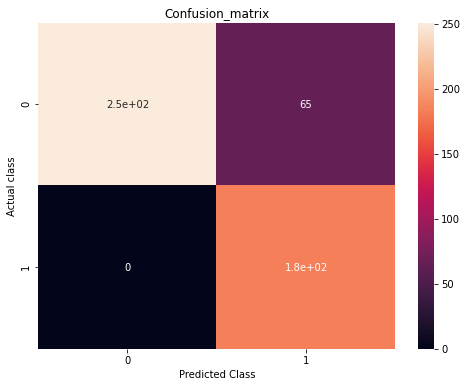

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [297]:
X_train,Y_train = smote.fit_sample(X_train,Y_train)
xgb = XGBClassifier(learning_rate=0.3, n_estimators=10, max_depth=2, min_child_weight=1, gamma=0, objective= 'binary:logistic', 
                    nthread=4, seed=1)

xgb.fit(X_train,Y_train)
Y_pred = xgb.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Predictions by Second Stage Classifiers Utilizing the Top 5 Features

# XGBoost

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.89       316
           1       0.74      1.00      0.85       184

    accuracy                           0.87       500
   macro avg       0.87      0.90      0.87       500
weighted avg       0.90      0.87      0.87       500



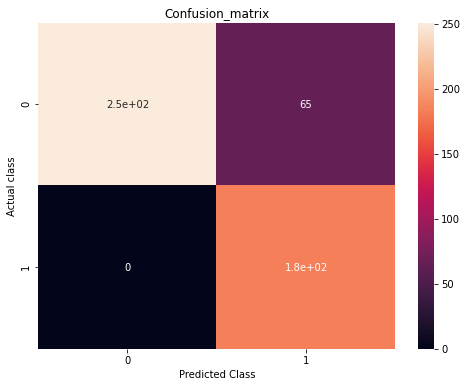

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [364]:
#Make Predictions and see the results
xgb = XGBClassifier(learning_rate=0.5, n_estimators=10, max_depth=2, min_child_weight=1, gamma=0, objective= 'binary:logistic', 
                    nthread=4, seed=1)

xgb.fit(X_train_Second_Stage,Y_train_Second_Stage)
Y_pred = xgb.predict(X_val

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Random Forest

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.89       316
           1       0.74      1.00      0.85       184

    accuracy                           0.87       500
   macro avg       0.87      0.90      0.87       500
weighted avg       0.90      0.87      0.87       500



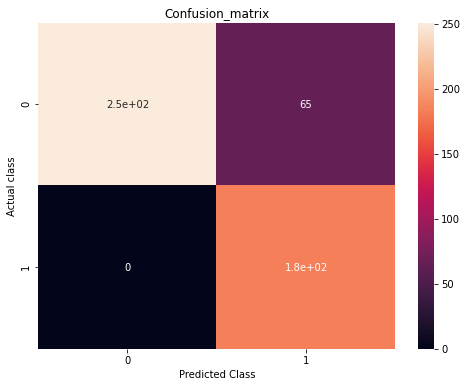

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [274]:
rfc = RandomForestClassifier(n_estimators=50, criterion='gini', max_features='auto', random_state=1)

rfc.fit(X_train_Second_Stage_Reduced_Features,Y_train_Second_Stage_Reduced_Features)
Y_pred = rfc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# AdaBoost

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.89       316
           1       0.74      1.00      0.85       184

    accuracy                           0.87       500
   macro avg       0.87      0.90      0.87       500
weighted avg       0.90      0.87      0.87       500



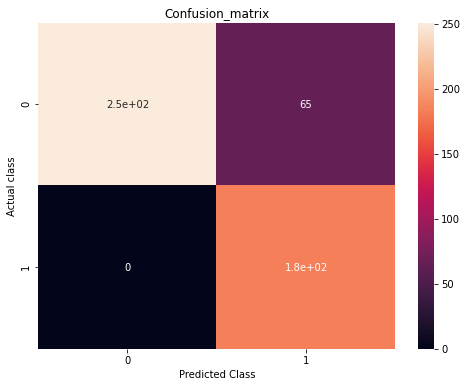

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [366]:
abc = AdaBoostClassifier(n_estimators=5, random_state=1)

abc.fit(X_train_Second_Stage,Y_train_Second_Stage)
Y_pred = abc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Gradient Boosting

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.89       316
           1       0.74      1.00      0.85       184

    accuracy                           0.87       500
   macro avg       0.87      0.90      0.87       500
weighted avg       0.90      0.87      0.87       500



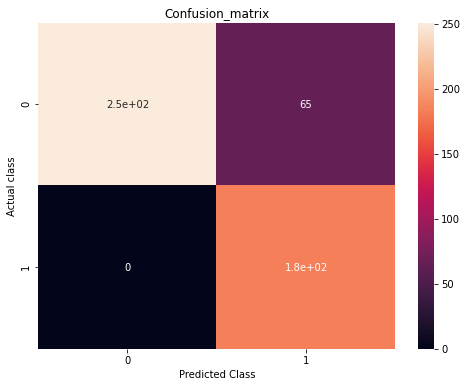

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [276]:
gbc = GradientBoostingClassifier(n_estimators= 10, max_depth=5, max_leaf_nodes=8, learning_rate=0.5, random_state=1)

gbc.fit(X_train_Second_Stage_Reduced_Features,Y_train_Second_Stage_Reduced_Features)
Y_pred = gbc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Support Vector Classifiers

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.89       316
           1       0.74      1.00      0.85       184

    accuracy                           0.87       500
   macro avg       0.87      0.90      0.87       500
weighted avg       0.90      0.87      0.87       500



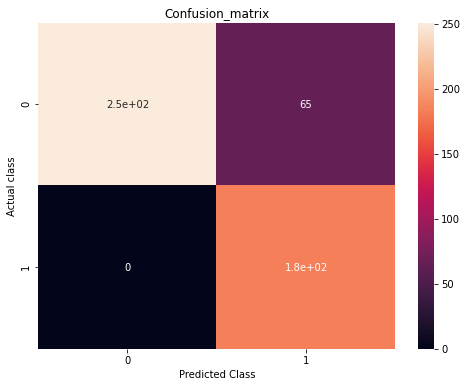

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [277]:
svc = SVC(C= 0.1, kernel='linear', gamma=1, random_state=1)

svc.fit(X_train_Second_Stage_Reduced_Features,Y_train_Second_Stage_Reduced_Features)

Y_pred = svc.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# Logistic Regression

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.89       316
           1       0.74      1.00      0.85       184

    accuracy                           0.87       500
   macro avg       0.87      0.90      0.87       500
weighted avg       0.90      0.87      0.87       500



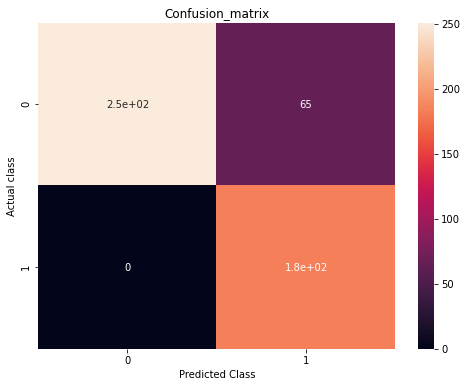

Confusion matrix: 
 [[251  65]
 [  0 184]]
TP:  184
TN:  251
FP:  65
FN:  0


In [278]:
lr = LogisticRegression(penalty='l2', C=100, random_state=1, solver='saga', max_iter=10000)
lr.fit(X_train_Second_Stage_Reduced_Features,Y_train_Second_Stage_Reduced_Features)

Y_pred = lr.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

# k-nearest neighbours

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.80      0.88       316
           1       0.74      0.99      0.85       184

    accuracy                           0.87       500
   macro avg       0.87      0.89      0.87       500
weighted avg       0.90      0.87      0.87       500



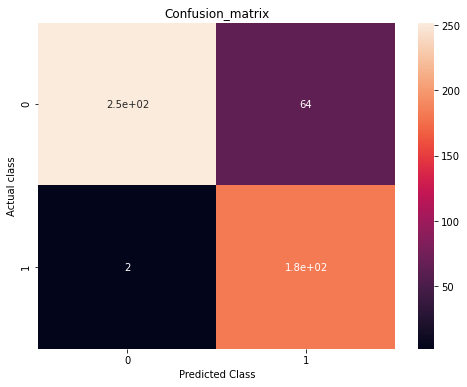

Confusion matrix: 
 [[252  64]
 [  2 182]]
TP:  182
TN:  252
FP:  64
FN:  2


In [372]:
knn = KNeighborsClassifier(n_neighbors=21, weights='uniform', algorithm='auto', leaf_size=1,p=1)
knn.fit(X_train_Second_Stage_Reduced_Features,Y_train_Second_Stage_Reduced_Features)

Y_pred = knn.predict(X_val)

print('Classification report: \n', metrics.classification_report(Y_val, Y_pred))

conf_mat = metrics.confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])